optuna-dashboard 起動メモ\
!hostname -i\
!optuna-dashboard --host "172.17.0.2"  "sqlite:///MachineLearning/OptunaLogs/2022-10-23/optuna.sqlite3"\
\
↓optuna.sqlite3に入っているログの一覧確認

In [ ]:
!optuna studies --storage "sqlite:///./OptunaLogs/2022-10-24/optuna.sqlite3"

# データの読み込み

In [1]:
!pwd

/mnt/MachineLearning/MLTrial


In [62]:
#tensorboardの拡張機能読み込み
%load_ext tensorboard

In [2]:
#warningはpythonの標準ライブラリ．
#FutureWarnigが邪魔なので非表示にする．動作に支障が無ければ問題ない．また最適化によって解が収束しないときに出るConvergenceWarningも邪魔なので非表示にする．
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=(FutureWarning, ConvergenceWarning))#対象のwarningsクラスはタプルで渡す必要があるらしい

In [3]:
import pprint
import sys
sys.path.append("/mnt/MachineLearning")
pprint.pprint(sys.path)

['/mnt/MachineLearning/MLTrial',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/mnt/MachineLearning']


In [4]:
#各種モジュールのimport
%matplotlib inline
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import statistics

from modules import show_mod
from modules.log_controler import ControlLog

from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import BatchNormalization
from keras.layers import ReLU, LeakyReLU, PReLU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, TensorBoard

import optuna

2022-12-01 05:53:12.447798: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


keras.layers.Activationには基礎的な活性化関数しか入っていない．\
LeakyReLUやELUなどの発展的な活性化関数を使用したい場合はkeras.layersに実装されているのでそこからimportする．

In [5]:
#読み込むデータのパスの設定
current_dir_path = os.getcwd()
data_path = "/mnt/MachineLearning/data"
input_list = glob.glob(data_path+"/*"+"/inputdata.csv")
output_list = glob.glob(data_path+"/CountResults"+"/sitting"+"/count_from2sec_patientAverage.csv")
num_input = len(input_list)

In [6]:
data_path

'/mnt/MachineLearning/data'

In [7]:
#input(空調条件等)の読み込み
df_input = None

for input_fname in input_list:
    df_read = pd.read_csv(input_fname, index_col="case_name")
    if df_input is None:
        df_input = df_read
    else:
        df_input = df_input.append(df_read)

df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,...,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,aircon_position_x,aircon_position_y
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_246_aout,660,246,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_82_bout,660,82,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_82_aout,660,82,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_164_bout,660,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5,4.25,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,b,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN
office6_660_0,660,0,off,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN
office6_360_246_aout,360,246,a,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5,NaN,NaN


In [8]:
#入力データの選択(オフィスサイズとエアコン位置が被っていると思うので削除)
delete_cols = ["aircon_position_x", "aircon_position_y"]
df_input.drop(df_input[delete_cols], axis=1, inplace=True)
df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,...,4_x,4_y,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_246_aout,660,246,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_82_bout,660,82,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_82_aout,660,82,a,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
office22_660_164_bout,660,164,b,3.570,4.235,1.255,270.0,5.020,4.235,1.255,...,4.180,2.315,1.255,90.0,5.630,2.315,1.255,90.0,8.5,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,b,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5
office6_660_0,660,0,off,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5
office6_360_246_aout,360,246,a,4.734,0.810,1.255,180.0,4.734,2.260,1.255,...,2.984,2.260,1.255,180.0,2.984,0.810,1.255,180.0,6.0,5.5


In [9]:
#排気口位置a,b,offをダミー変数化
df_input = pd.get_dummies(df_input, columns=['exhaust'])
df_input

,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,...,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0
office22_660_246_aout,660,246,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,90.0,5.630,2.315,1.255,90.0,8.5,6.5,1,0,0
office22_660_82_bout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0
office22_660_82_aout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,90.0,5.630,2.315,1.255,90.0,8.5,6.5,1,0,0
office22_660_164_bout,660,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,90.0,5.630,2.315,1.255,90.0,8.5,6.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,180.0,2.984,0.810,1.255,180.0,6.0,5.5,0,1,0
office6_660_0,660,0,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,180.0,2.984,0.810,1.255,180.0,6.0,5.5,0,0,1
office6_360_246_aout,360,246,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,180.0,2.984,0.810,1.255,180.0,6.0,5.5,1,0,0


In [10]:
df_output = pd.read_csv(output_list[0], index_col="casename")
df_output

,num_drop,volume[ml],RoI
casename,,,
office2_0_0,6739.4,0.000067,204.224242
office2_0_164_aout,7865.4,0.000063,238.345455
office2_0_164_bout,6049.8,0.000062,183.327273
office2_0_246_aout,7934.4,0.000050,240.436364
office2_0_246_bout,7662.0,0.000082,232.181818
...,...,...,...
office3_960_164_bout,5117.4,0.000075,155.072727
office3_960_246_aout,4428.0,0.000073,134.181818
office3_960_246_bout,3890.0,0.000066,117.878788


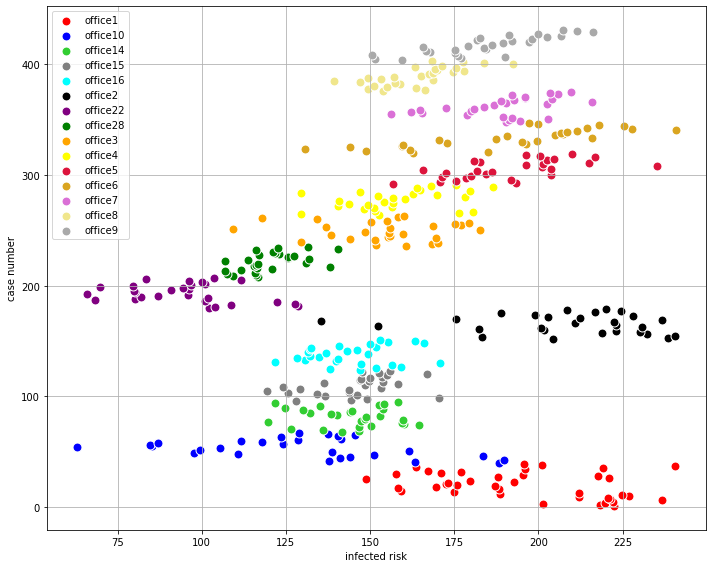

In [11]:
#df_outputの値の幅を見てみる
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_output.index.str.extract("(office+[0-9]{1,2})").to_numpy()

plt.figure(figsize=[10, 8])

#カラーマップ等の準備
markers = ("s", "x", "o", "^", "v", "<", ">", "1", "2", "3", "4", "8")
colors = ("red", "blue", "limegreen", "gray", "cyan", "black", "purple", "green",
          "orange", "yellow", "crimson", "goldenrod", "orchid", "khaki", "darkgray")
start_index = 0

for idx, target_office_name in enumerate(np.unique(office_list)):
    target_office_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == target_office_name)]
    plt.scatter(df_output.iloc[target_office_index ,2], range(1+start_index, len(target_office_index)+1+start_index), 
                s=80, c=colors[idx], marker=markers[2], edgecolor="white", label=target_office_name)
    start_index += len(target_office_index)
    

plt.ylabel("case number")
plt.xlabel("infected risk")
plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [12]:
df_total = pd.merge(df_input, df_output, left_index=True, right_index=True)
print(f"num null in df:{df_total.isnull().values.sum()}")#結合が上手く行っていないかどうか確認
df_total

num null in df:0


,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,...,5_z,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off,num_drop,volume[ml],RoI
office22_360_164_bout,360,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,1.255,90.0,8.5,6.5,0,1,0,5629.6,0.000047,101.893213
office22_660_246_aout,660,246,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,1.255,90.0,8.5,6.5,1,0,0,5321.0,0.000041,96.307692
office22_660_82_bout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,1.255,90.0,8.5,6.5,0,1,0,4394.8,0.000048,79.543891
office22_660_82_aout,660,82,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,1.255,90.0,8.5,6.5,1,0,0,3848.2,0.000035,69.650679
office22_660_164_bout,660,164,3.570,4.235,1.255,270.0,5.020,4.235,1.255,270.0,...,1.255,90.0,8.5,6.5,0,1,0,5014.6,0.000059,90.761991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,1.255,180.0,6.0,5.5,0,1,0,6504.6,0.000077,197.109091
office6_660_0,660,0,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,1.255,180.0,6.0,5.5,0,0,1,7121.0,0.000096,215.787879
office6_360_246_aout,360,246,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,1.255,180.0,6.0,5.5,1,0,0,6435.6,0.000058,195.018182
office6_960_0,960,0,4.734,0.810,1.255,180.0,4.734,2.260,1.255,180.0,...,1.255,180.0,6.0,5.5,0,0,1,7945.2,0.000093,240.763636


In [13]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, office22_360_164_bout to office6_960_246_bout
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   aircon         431 non-null    int64  
 1   ventilation    431 non-null    int64  
 2   1_x            431 non-null    float64
 3   1_y            431 non-null    float64
 4   1_z            431 non-null    float64
 5   1_angle        431 non-null    float64
 6   2_x            431 non-null    float64
 7   2_y            431 non-null    float64
 8   2_z            431 non-null    float64
 9   2_angle        431 non-null    float64
 10  3_x            431 non-null    float64
 11  3_y            431 non-null    float64
 12  3_z            431 non-null    float64
 13  3_angle        431 non-null    float64
 14  4_x            431 non-null    float64
 15  4_y            431 non-null    float64
 16  4_z            431 non-null    float64
 17  4_angle        431 non

# 統計分析

In [14]:
#基礎統計量について確認
df_total.describe()

,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,...,5_z,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off,num_drop,volume[ml],RoI
count,431.000000,431.000000,431.000000,431.000000,4.310000e+02,431.000000,431.000000,431.000000,4.310000e+02,431.000000,...,4.310000e+02,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,499.071926,139.837587,3.337392,2.765791,1.255000e+00,86.450116,3.618077,3.061318,1.255000e+00,147.215777,...,1.255000e+00,119.234339,7.364269,5.370070,0.431555,0.431555,0.136891,6130.170302,0.000066,161.902247
std,360.876287,83.985694,1.939957,1.115080,4.446053e-16,83.972153,1.242520,0.838024,4.446053e-16,103.603211,...,4.446053e-16,90.054858,1.370630,0.754404,0.495869,0.495869,0.344132,921.844114,0.000017,36.376848
min,0.000000,0.000000,0.560000,0.810000,1.255000e+00,0.000000,1.266000,0.940000,1.255000e+00,0.000000,...,1.255000e+00,0.000000,6.000000,4.000000,0.000000,0.000000,0.000000,2644.400000,0.000025,62.961905
25%,0.000000,82.000000,1.266000,2.180000,1.255000e+00,0.000000,2.930000,2.540000,1.255000e+00,90.000000,...,1.255000e+00,90.000000,6.000000,5.000000,0.000000,0.000000,0.000000,5540.500000,0.000055,138.530952
50%,660.000000,164.000000,3.570000,3.016000,1.255000e+00,90.000000,3.285000,3.059000,1.255000e+00,90.000000,...,1.255000e+00,90.000000,7.000000,5.500000,0.000000,0.000000,0.000000,6169.400000,0.000065,159.866667
75%,960.000000,246.000000,4.760000,3.820000,1.255000e+00,180.000000,4.760000,3.575000,1.255000e+00,270.000000,...,1.255000e+00,180.000000,9.000000,6.000000,1.000000,1.000000,0.000000,6791.400000,0.000076,188.787879
max,960.000000,246.000000,7.735000,4.515000,1.255000e+00,270.000000,6.260000,4.515000,1.255000e+00,270.000000,...,1.255000e+00,270.000000,9.500000,6.500000,1.000000,1.000000,1.000000,8008.600000,0.000130,240.763636


In [15]:
#口のz座標は全て同じであることがわかり特徴量として機能しないので削除
delete_cols = ["1_z","2_z","3_z","4_z","5_z"]
df_total.drop(df_total[delete_cols], axis=1, inplace=True)
df_total

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off,num_drop,volume[ml],RoI
office22_360_164_bout,360,164,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,2.315,90.0,8.5,6.5,0,1,0,5629.6,0.000047,101.893213
office22_660_246_aout,660,246,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,2.315,90.0,8.5,6.5,1,0,0,5321.0,0.000041,96.307692
office22_660_82_bout,660,82,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,2.315,90.0,8.5,6.5,0,1,0,4394.8,0.000048,79.543891
office22_660_82_aout,660,82,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,2.315,90.0,8.5,6.5,1,0,0,3848.2,0.000035,69.650679
office22_660_164_bout,660,164,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,2.315,90.0,8.5,6.5,0,1,0,5014.6,0.000059,90.761991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,0.810,180.0,6.0,5.5,0,1,0,6504.6,0.000077,197.109091
office6_660_0,660,0,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,0.810,180.0,6.0,5.5,0,0,1,7121.0,0.000096,215.787879
office6_360_246_aout,360,246,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,0.810,180.0,6.0,5.5,1,0,0,6435.6,0.000058,195.018182
office6_960_0,960,0,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,0.810,180.0,6.0,5.5,0,0,1,7945.2,0.000093,240.763636


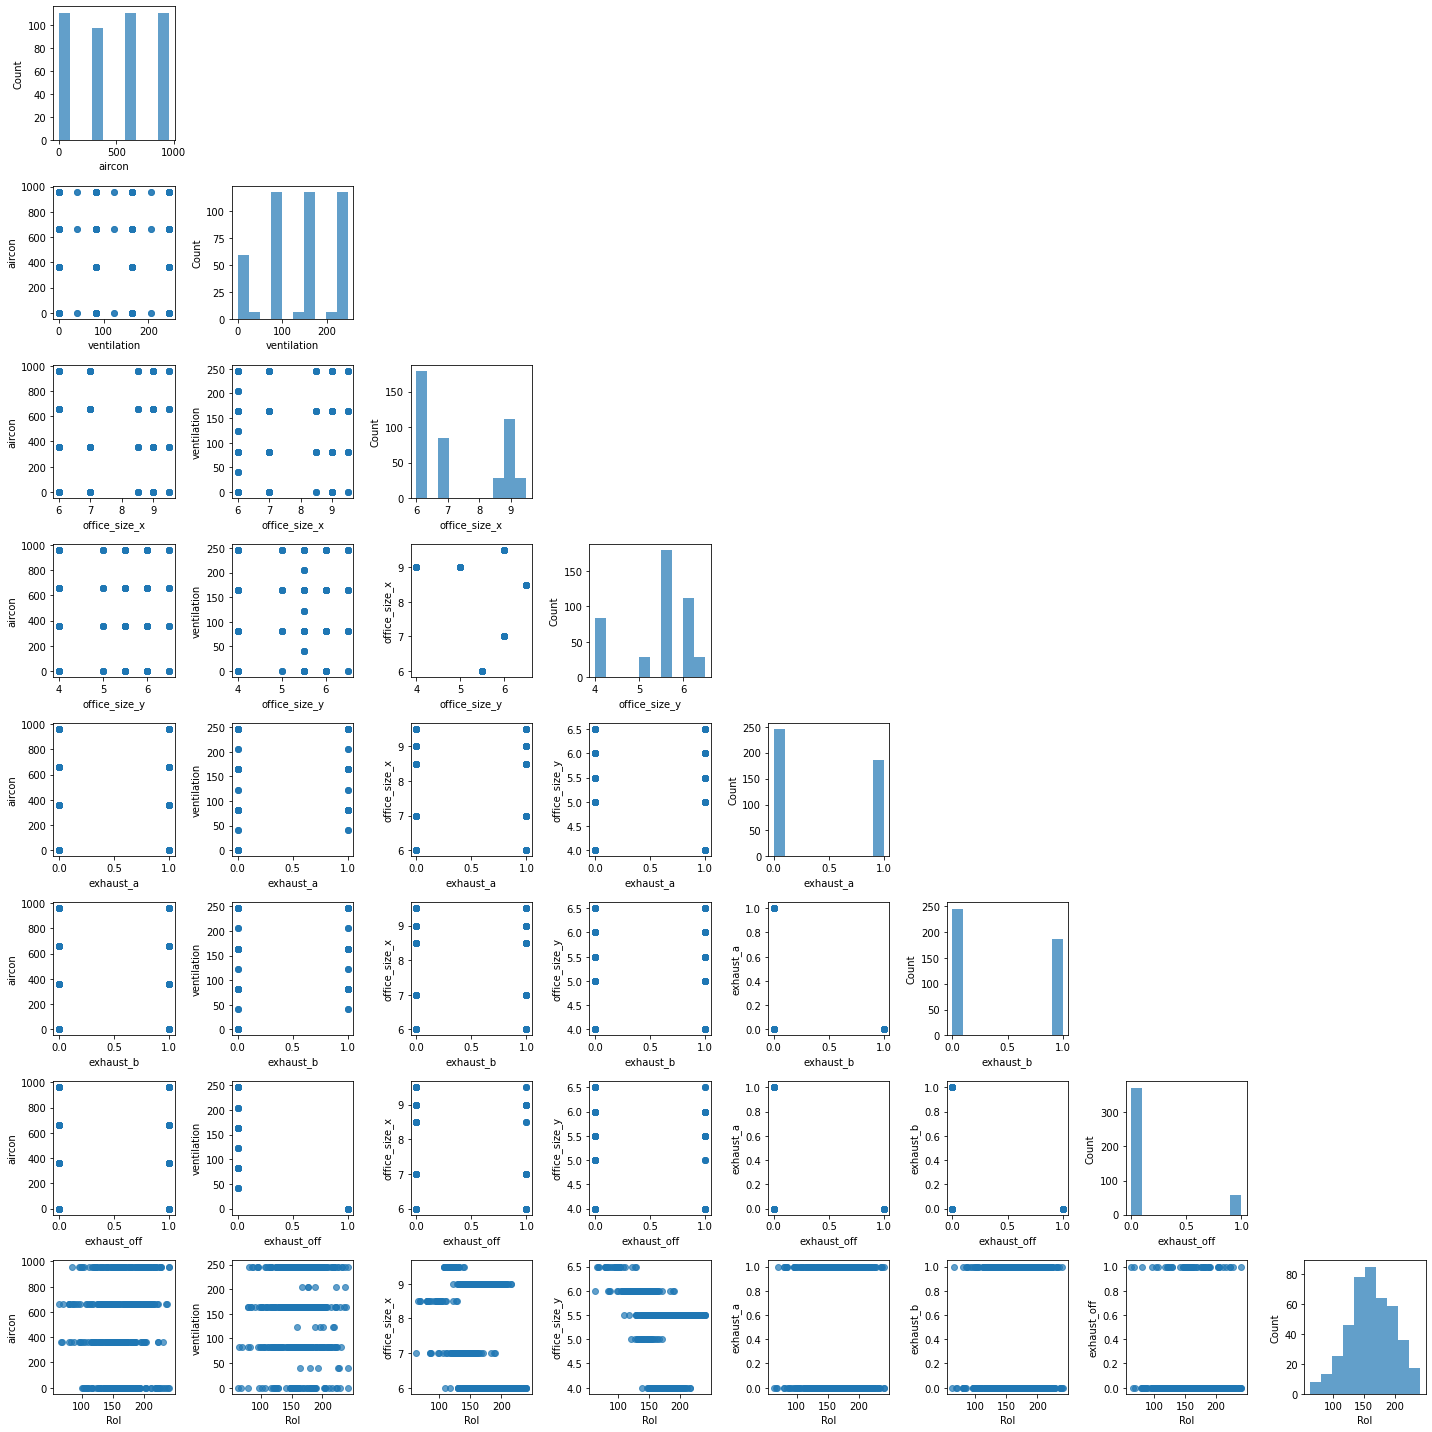

In [16]:
plot_cols = ["aircon", "ventilation", "office_size_x", "office_size_y", "exhaust_a", "exhaust_b", "exhaust_off", "RoI"]
# plot_cols = ['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y',"RoI"]
# plot_cols = ['1_angle','2_angle','3_angle','4_angle','5_angle',"RoI"]
scatterplotmatrix(df_total[plot_cols].values, figsize=(20, 20), names=plot_cols, alpha=0.7)
plt.tight_layout()
plt.show()

外れ値の確認などもここで行っておくとよい．

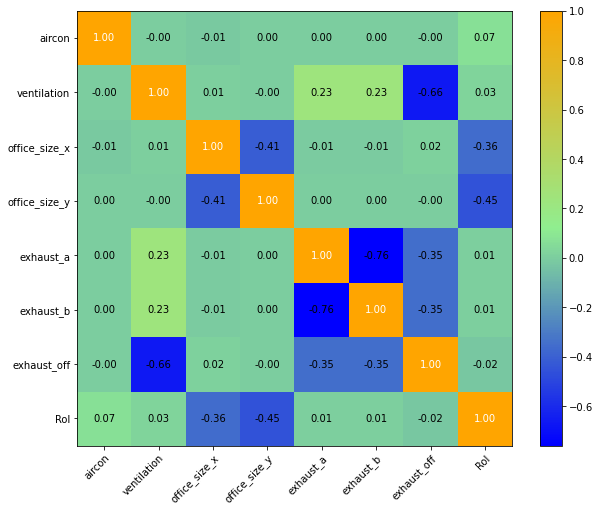

In [17]:
#ピアソンの積率相関係数のヒートマップ（ピアソンの積率相関係数はスケーリングした共分散）
cmap = show_mod.make_colormap(["blue", "lightgreen", "orange"])
correlationcoefficient = df_total[plot_cols].corr().to_numpy()
heat_map = heatmap(correlationcoefficient, figsize=(10, 8), cmap=cmap, row_names=plot_cols, column_names=plot_cols)
plt.show()

# データの前処理 

In [18]:
#説明変数と目的変数の定義
explanatory_variable =['aircon', 'ventilation', '1_x', '1_y', '1_angle', '2_x', '2_y',
                       '2_angle', '3_x', '3_y', '3_angle', '4_x', '4_y', '4_angle', '5_x', '5_y', '5_angle',
                       'office_size_x','office_size_y', 'exhaust_a', 'exhaust_b', 'exhaust_off']
objective_variable = ["RoI"]

df_explanatory_variable = df_total[explanatory_variable]
df_objective_variable = df_total[objective_variable]

**標準化について**\
scikit-learnによる線型回帰では勾配降下法に基づく最適化を行わず，scipyの最小二乗法の実装に使用されているLAPACKに基づく高度な最適化手法を利用している．\
そのため使用する変数を標準化する必要がなく，寧ろ標準化しない方が上手く行くらしい．\
勾配降下法適用時に標準化する理由としては特徴量をスケーリングすることで，各特徴量に基づくパラメータ更新幅を揃えることができ，\
結果として誤差関数の収束が早くなったりする．\
標準化を行うべきかどうかは，用いる機械学習アルゴリズムによって異なるため，その都度考える必要がある．

In [19]:
#説明変数の標準化(only explanatory variable)
#目的変数は標準化する意味がないため，するべきではない．
stdscaler = preprocessing.StandardScaler()
stdscaler.fit(df_explanatory_variable)
np_explanatory_variable_std = stdscaler.transform(df_explanatory_variable)
df_explanatory_variable_std = pd.DataFrame(np_explanatory_variable_std, index=df_explanatory_variable.index, columns=df_explanatory_variable.columns)
df_explanatory_variable_std

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office22_360_164_bout,-0.385821,0.288031,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,...,0.247892,-0.325005,1.617954,0.647805,-0.325005,0.829582,1.499520,-0.871311,1.147695,-0.398249
office22_660_246_aout,0.446455,1.265523,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,...,0.247892,-0.325005,1.617954,0.647805,-0.325005,0.829582,1.499520,1.147695,-0.871311,-0.398249
office22_660_82_bout,0.446455,-0.689460,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,...,0.247892,-0.325005,1.617954,0.647805,-0.325005,0.829582,1.499520,-0.871311,1.147695,-0.398249
office22_660_82_aout,0.446455,-0.689460,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,...,0.247892,-0.325005,1.617954,0.647805,-0.325005,0.829582,1.499520,1.147695,-0.871311,-0.398249
office22_660_164_bout,0.446455,0.288031,0.120043,1.319112,2.188382,1.129601,1.402163,1.186516,-0.314246,-0.429014,...,0.247892,-0.325005,1.617954,0.647805,-0.325005,0.829582,1.499520,-0.871311,1.147695,-0.398249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,1.278731,-0.689460,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office6_660_0,0.446455,-1.666952,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,-0.871311,-0.871311,2.510993
office6_360_246_aout,-0.385821,1.265523,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office6_960_0,1.278731,-1.666952,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,-0.871311,-0.871311,2.510993


In [20]:
df_explanatory_variable
# df_explanatory_variable_std
# df_objective_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office22_360_164_bout,360,164,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,2.315,90.0,5.630,2.315,90.0,8.5,6.5,0,1,0
office22_660_246_aout,660,246,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,2.315,90.0,5.630,2.315,90.0,8.5,6.5,1,0,0
office22_660_82_bout,660,82,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,2.315,90.0,5.630,2.315,90.0,8.5,6.5,0,1,0
office22_660_82_aout,660,82,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,2.315,90.0,5.630,2.315,90.0,8.5,6.5,1,0,0
office22_660_164_bout,660,164,3.570,4.235,270.0,5.020,4.235,270.0,2.730,2.315,...,2.315,90.0,5.630,2.315,90.0,8.5,6.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office6_960_82_bout,960,82,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,2.260,180.0,2.984,0.810,180.0,6.0,5.5,0,1,0
office6_660_0,660,0,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,2.260,180.0,2.984,0.810,180.0,6.0,5.5,0,0,1
office6_360_246_aout,360,246,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,2.260,180.0,2.984,0.810,180.0,6.0,5.5,1,0,0
office6_960_0,960,0,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,2.260,180.0,2.984,0.810,180.0,6.0,5.5,0,0,1


**同じ形状のオフィス一覧**\
office1-6\
office7-9\
office10-15\
office16-21\
office22-27\
office28-33

In [21]:
#特定のofficeだけテストデータにする
target_office_name = ["office10"]
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_total.index.str.extract("(office+[0-9]{1,2})").to_numpy()
print(f"office list in data:\n{np.unique(office_list)}")
#リスト内包表記
test_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == target_office_name)]
#test_data_index以外をtrain_data_indexとする
train_data_bool = np.ones(office_list.shape[0], dtype = bool)
train_data_bool[test_data_index] = False
train_data_index = np.arange(office_list.shape[0])[train_data_bool]

office list in data:
['office1' 'office10' 'office14' 'office15' 'office16' 'office2'
 'office22' 'office28' 'office3' 'office4' 'office5' 'office6' 'office7'
 'office8' 'office9']


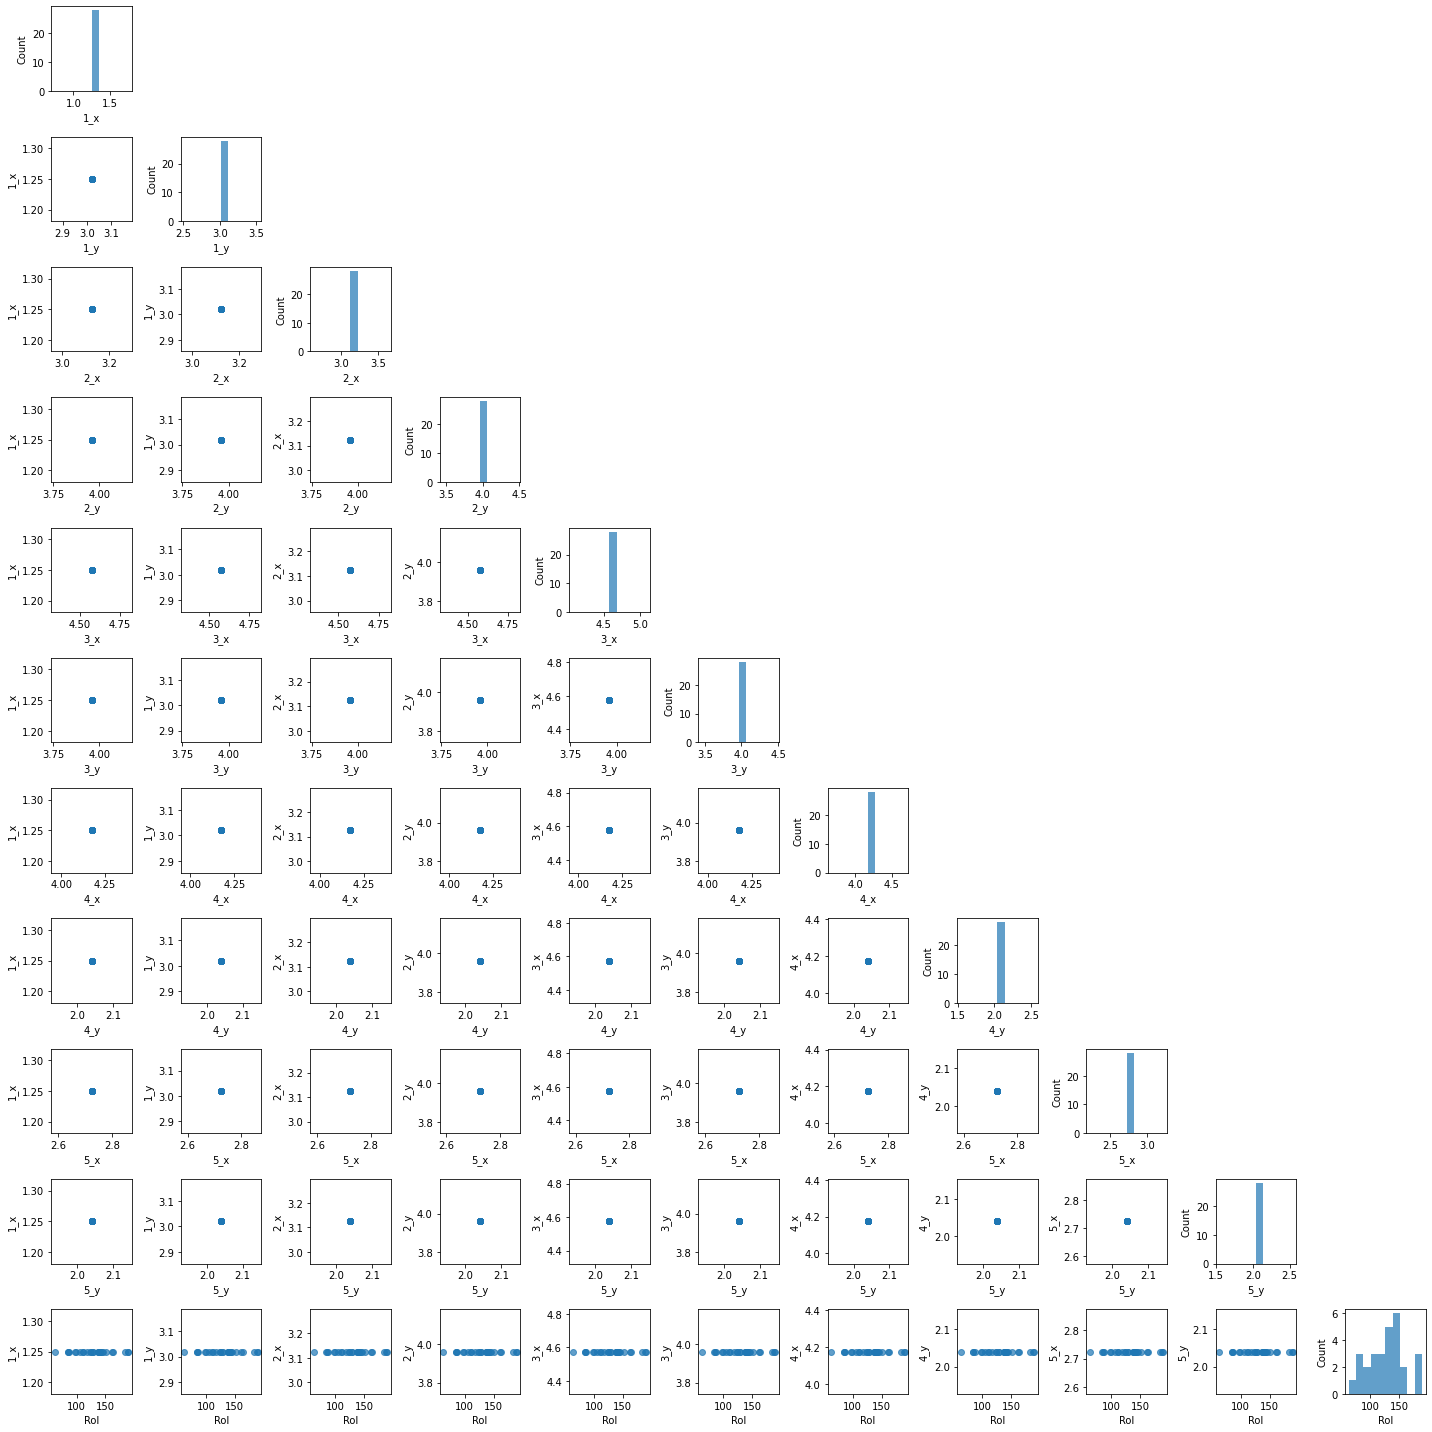

In [22]:
#各オフィスで分けて統計解析してみる(同じ形状のオフィスだけで関係を見たりしたいときに使う)
# plot_cols = ["aircon", "ventilation", "office_size_x", "office_size_y", "exhaust_a", "exhaust_b", "exhaust_off", "RoI"]
plot_cols = ['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y',"RoI"]
# plot_cols = ['1_angle','2_angle','3_angle','4_angle','5_angle',"RoI"]
df_target_office = df_total.iloc[test_data_index]
scatterplotmatrix(df_target_office[plot_cols].values, figsize=(20, 20), names=plot_cols, alpha=0.7)
plt.tight_layout()
plt.show()

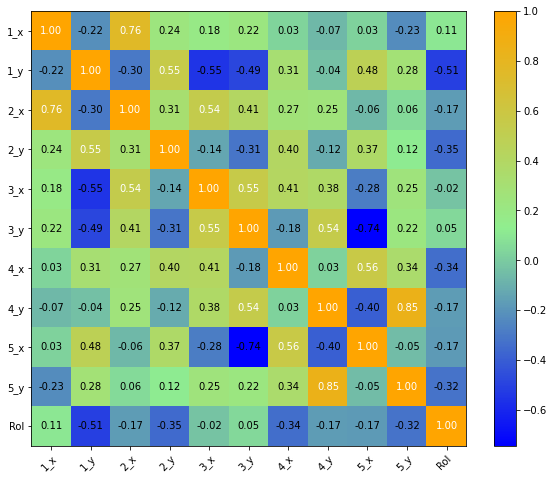

In [23]:
#ピアソンの積率相関係数のヒートマップ（ピアソンの積率相関係数はスケーリングした共分散）
cmap = show_mod.make_colormap(["blue", "lightgreen", "orange"])
correlationcoefficient = df_total[plot_cols].corr().to_numpy()
heat_map = heatmap(correlationcoefficient, figsize=(10, 8), cmap=cmap, row_names=plot_cols, column_names=plot_cols)
plt.show()

# 回帰分析

# 線形回帰（線形重回帰）

今回は説明変数の数が一つではないため単回帰ではなく，重回帰となる．

In [34]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
# train_explanatory_variable
# train_objective_variable
# test_objective_variable
test_explanatory_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office10_360_164_bout,360,164,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,0,1,0
office10_660_246_aout,660,246,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,1,0,0
office10_660_82_bout,660,82,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,0,1,0
office10_660_82_aout,660,82,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,1,0,0
office10_660_164_bout,660,164,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,0,1,0
office10_0_164_aout,0,164,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,1,0,0
office10_0_82_aout,0,82,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,1,0,0
office10_660_164_aout,660,164,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,1,0,0
office10_660_246_bout,660,246,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,0,1,0
office10_360_246_bout,360,246,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,0,1,0


In [35]:
linear_model = LinearRegression()

In [36]:
#k分割交差検証の実装
#評価指標の決定
metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
#交差検証の分割方法を決定
kf = KFold(n_splits=10, shuffle=True, random_state=1)

scikit-learnによる交差検証では，よく"cross_val_score"が用いられるがこれは少し古く，\
現在は"cross_validate"というものがある．こちらではscoringにリストやタプル，辞書型を用いて複数の評価指標を与えることができる．\
まあfor文を使えばcross_val_scoreでも複数のscoringを使用することは簡単にできるけどね．

In [37]:
scores = cross_validate(estimator=linear_model, scoring=metrics,
                         X=train_explanatory_variable, y=train_objective_variable, 
                         cv=kf, n_jobs=1, verbose=1, return_train_score=True)
pprint.pprint(scores)

{'fit_time': array([0.01473165, 0.0047462 , 0.00325441, 0.00293279, 0.00276709,
       0.00267076, 0.0027318 , 0.00266623, 0.00252438, 0.00258064]),
 'score_time': array([0.00828958, 0.00422978, 0.00340652, 0.00348806, 0.00353003,
       0.00330377, 0.00348163, 0.00326586, 0.0032413 , 0.00327063]),
 'test_neg_mean_absolute_error': array([-12.60019911, -13.24978118, -12.73037603, -13.79201755,
       -11.81849184, -14.3430461 , -14.52232435, -15.70829889,
       -14.97771162, -11.2884688 ]),
 'test_neg_mean_squared_error': array([-253.70879767, -336.27064743, -279.16804285, -375.24281224,
       -236.68587211, -318.34268132, -391.22722888, -408.05081158,
       -369.81355167, -214.46735292]),
 'test_r2': array([0.74858519, 0.72043559, 0.78812539, 0.67411964, 0.78475455,
       0.66857817, 0.76070401, 0.74491109, 0.69682104, 0.79342781]),
 'train_neg_mean_absolute_error': array([-13.02898683, -13.02477137, -13.09806487, -12.87837844,
       -13.2288899 , -12.81211197, -12.94275445, -12.7

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


n_jobsは使用するcpuの個数．これぐらいの軽い処理なら，分割せず1つでやった方が分割の処理に時間がかからないので逆に早い．

In [38]:
print("交差検証結果の平均値")
print("test_r2 score:", scores["test_r2"].mean())
print("test_neg_mean_squared_error:", scores["test_neg_mean_squared_error"].mean())
print("test_neg_mean_absolute_error:", scores["test_neg_mean_absolute_error"].mean())

交差検証結果の平均値
test_r2 score: 0.7380462482034876
test_neg_mean_squared_error: -318.29777986688674
test_neg_mean_absolute_error: -13.50307154699659


In [39]:
linear_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = linear_model.predict(train_explanatory_variable)
test_pred = linear_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{linear_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{linear_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")

テストデータを用いた結果
r2 train score:0.7659486094958154
MSE train score:296.5884922020521
r2 test score:-1.4600521561446063
MSE test score:2396.3730021719325


/mnt/MachineLearning/modules/show_mod.py:86: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


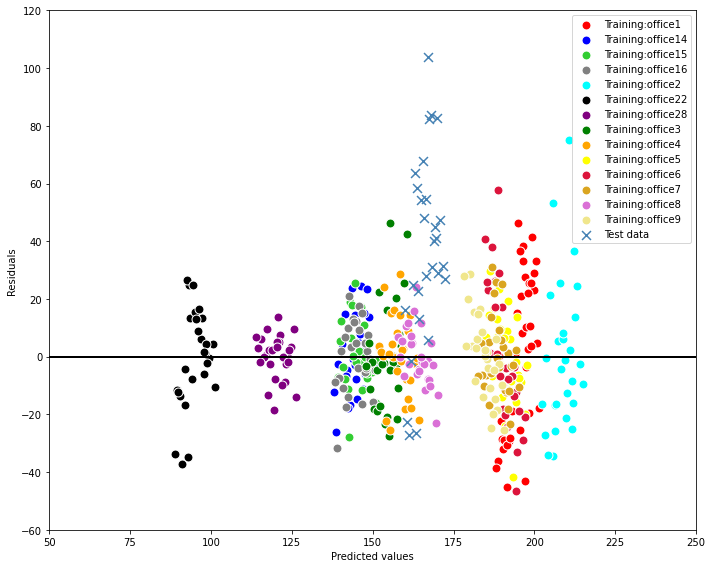

In [30]:
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()

#残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy(), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy(), 
                            office_list=office_list)

今回は線形重回帰を標準化せずに行ったが標準化した方が良いと思われる．\
回帰式からもわかるように回帰係数は各説明変数の目的変数への影響度合いを表しており，\
説明変数を標準化していた場合はそれぞれの回帰係数について評価することが可能になる．\
ここで回帰係数から影響度合いを見たいときは回帰係数がまともな値なのかを判断する必要がある．\
例えば説明変数が多い場合，説明変数同士が相関しているようなものが含まれていると，多重共線性の問題から，回帰係数の解釈は難しくなる．\
説明変数同士の相関を分析するときに使えるのが**分散拡大係数（VIF）**

## Lasso回帰

Lassoは正則化の特徴からパラメータのスケールによってペナルティを与えるので標準化必須

In [31]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
train_explanatory_variable
# train_objective_variable
# test_objective_variable

,RoI
office10_360_164_bout,97.747619
office10_660_246_aout,124.204762
office10_660_82_bout,111.785714
office10_660_82_aout,117.776190
office10_660_164_bout,84.561905
office10_0_164_aout,163.342857
office10_0_82_aout,143.985714
office10_660_164_aout,85.161905
office10_660_246_bout,87.109524
office10_360_246_bout,161.519048


In [32]:
#ラッソー回帰のインスタンス作成
lasso_model = Lasso(alpha=1.0)

In [33]:
#k分割交差検証の実装
#評価指標の決定
metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
#交差検証の分割方法を決定
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [34]:
scores = cross_validate(estimator=lasso_model, scoring=metrics,
                         X=train_explanatory_variable, y=train_objective_variable, 
                         cv=kf, n_jobs=1, verbose=1, return_train_score=True)
pprint.pprint(scores)

{'fit_time': array([0.00815773, 0.00365186, 0.00250602, 0.00241923, 0.00251341,
       0.00227928, 0.00235891, 0.00224829, 0.00419164, 0.00291705]),
 'score_time': array([0.00728178, 0.00446367, 0.00358057, 0.00345874, 0.00344706,
       0.00332332, 0.00331879, 0.00751519, 0.00577354, 0.00383067]),
 'test_neg_mean_absolute_error': array([-15.68955816, -12.81117584, -13.84830116, -16.7571363 ,
       -13.01899597, -13.39275346, -15.84966692, -14.65317767,
       -15.34886718, -13.62089008]),
 'test_neg_mean_squared_error': array([-404.74202495, -321.0905813 , -314.15899519, -445.86602918,
       -283.89560987, -342.09918615, -459.72855853, -372.28079567,
       -320.5544149 , -290.26775407]),
 'test_r2': array([0.69336291, 0.74932255, 0.74338061, 0.7393003 , 0.74254454,
       0.62621804, 0.57726342, 0.74752055, 0.77756778, 0.70518945]),
 'train_neg_mean_absolute_error': array([-14.07891839, -14.31643609, -14.21051553, -14.10856416,
       -14.30169481, -14.32342207, -13.81231853, -14.2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [35]:
print("交差検証結果の平均値")
print("test_r2 score:", scores["test_r2"].mean())
print("test_neg_mean_squared_error:", scores["test_neg_mean_squared_error"].mean())
print("test_neg_mean_absolute_error:", scores["test_neg_mean_absolute_error"].mean())

交差検証結果の平均値
test_r2 score: 0.7101670139043896
test_neg_mean_squared_error: -355.4683949803561
test_neg_mean_absolute_error: -14.499052274029955


In [36]:
lasso_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = lasso_model.predict(train_explanatory_variable)
test_pred = lasso_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{lasso_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{lasso_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")

テストデータを用いた結果
r2 train score:0.7307491128795215
MSE train score:341.19307927674924
r2 test score:-1.7771272044943318
MSE test score:2705.240472168361


/mnt/MachineLearning/modules/show_mod.py:88: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


<Figure size 720x576 with 0 Axes>

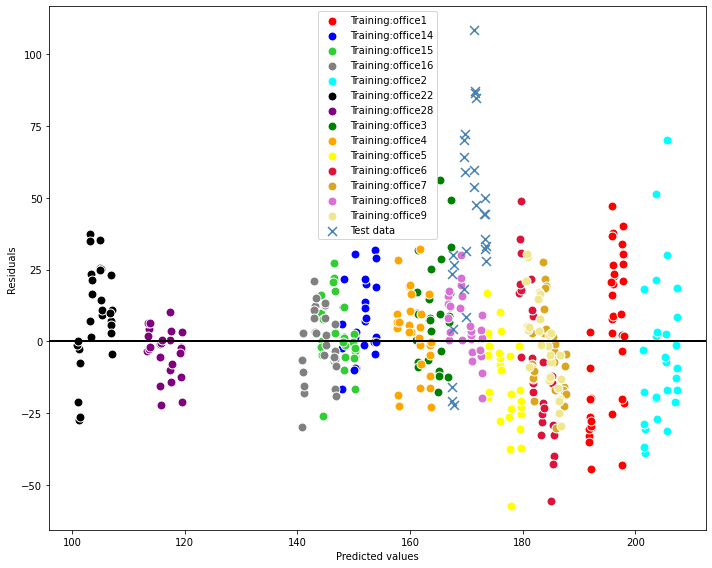

In [37]:
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()

show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().reshape(-1), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy().reshape(-1), 
                            office_list=office_list)

### optunaと交差検証を使用したハイパーパラメータ調整（自動最適化）

In [40]:
class Objective:
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        params = {
            "alpha" : trial.suggest_loguniform("alpha", 0.0001, 10),
            "max_iter" : trial.suggest_int("max_iter", 100, 100000)
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = Lasso(**params)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=True)
        
        self.bar.update(1)
        
        return scores["test_r2"].mean()
        
        #複数の目的関数を戻り値とする
#         return scores["test_r2"].mean(), scores["test_neg_mean_squared_error"].mean()

In [41]:
model_name = "Lasso"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=100
timeout=None
n_jobs=-1

try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)
    
    """
    複数の目的関数を持つときはmulti_objectiveモジュールを使用する
    複数の目的関数を最適化するのは多目的最適化と呼ばれ，専用の最適化アルゴリズムを指定する必要がある．単一目的関数の場合と比較する必要があるかもしれない．
    directionは目的関数がどうなるように最適化したいか．samplerが多目的最適化アルゴリズム．defaultはNSGAIIMultiObjectiveSampler
    """

    # study = optuna.multi_objective.create_study(directions=["maximize", "minimize"],
    #                                             sampler=optuna.multi_objective.samplers.NSGAIIMultiObjectiveSampler(seed=1), 
    #                                             storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-10-30/optuna.sqlite3


  0%|          | 0/100 [00:00<?, ?it/s]

study name: 10434


'\n複数の目的関数を持つときはmulti_objectiveモジュールを使用する\n複数の目的関数を最適化するのは多目的最適化と呼ばれ，専用の最適化アルゴリズムを指定する必要がある．単一目的関数の場合と比較する必要があるかもしれない．\ndirectionは目的関数がどうなるように最適化したいか．samplerが多目的最適化アルゴリズム．defaultはNSGAIIMultiObjectiveSampler\n'

In [42]:
#探索の結果最も良かったscore
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

best score: 0.7339859335044931
best params: {'alpha': 0.03908467587891366, 'max_iter': 42095}


テストデータを用いた結果
r2 train score:0.7655461242856494
MSE train score:297.09851900154956
r2 test score:-1.698530110044381
MSE test score:2628.67788599775


/mnt/MachineLearning/modules/show_mod.py:88: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


<Figure size 720x576 with 0 Axes>

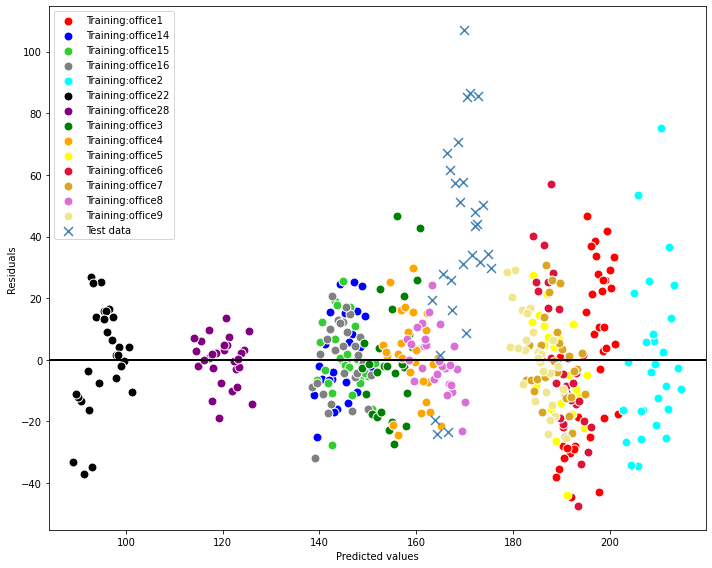

In [43]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = Lasso(alpha=study.best_params["alpha"], max_iter=study.best_params["max_iter"])
best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")


#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().reshape(-1), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy().reshape(-1), 
                            office_list=office_list)

## Ridge回帰

In [44]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
train_explanatory_variable
# train_objective_variable
# test_objective_variable

,RoI
office10_360_164_bout,97.747619
office10_660_246_aout,124.204762
office10_660_82_bout,111.785714
office10_660_82_aout,117.776190
office10_660_164_bout,84.561905
office10_0_164_aout,163.342857
office10_0_82_aout,143.985714
office10_660_164_aout,85.161905
office10_660_246_bout,87.109524
office10_360_246_bout,161.519048


In [45]:
#リッジ回帰のインスタンス作成
ridge_model = Ridge(alpha=1.0)

In [46]:
#k分割交差検証の実装
#評価指標の決定
metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
#交差検証の分割方法を決定
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [47]:
scores = cross_validate(estimator=ridge_model, scoring=metrics,
                         X=train_explanatory_variable, y=train_objective_variable, 
                         cv=kf, n_jobs=1, verbose=1, return_train_score=True)
pprint.pprint(scores)

{'fit_time': array([0.00892711, 0.00354981, 0.00244164, 0.00214911, 0.0021801 ,
       0.00216269, 0.00211596, 0.00209928, 0.00195336, 0.00204182]),
 'score_time': array([0.00867677, 0.00482011, 0.0035665 , 0.00338197, 0.00337791,
       0.00349236, 0.00334191, 0.00331855, 0.00314403, 0.00329208]),
 'test_neg_mean_absolute_error': array([-14.95643352, -12.82902495, -13.27157646, -13.76954936,
       -12.36961432, -12.58376158, -16.33124734, -12.90537834,
       -13.55676528, -13.62984316]),
 'test_neg_mean_squared_error': array([-366.55788065, -297.52743348, -285.10430775, -333.9629197 ,
       -272.67185197, -314.16017617, -503.98782895, -272.90021984,
       -256.6732623 , -297.84079469]),
 'test_r2': array([0.72229164, 0.76771845, 0.7671138 , 0.80473051, 0.75272299,
       0.65674456, 0.53656546, 0.81492009, 0.82189481, 0.69749789]),
 'train_neg_mean_absolute_error': array([-12.76193486, -13.09308299, -12.92307994, -12.99015399,
       -13.23623296, -13.26000824, -12.659858  , -13.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [48]:
print("交差検証結果の平均値")
print("test_r2 score:", scores["test_r2"].mean())
print("test_neg_mean_squared_error:", scores["test_neg_mean_squared_error"].mean())
print("test_neg_mean_absolute_error:", scores["test_neg_mean_absolute_error"].mean())

交差検証結果の平均値
test_r2 score: 0.7342200200841839
test_neg_mean_squared_error: -320.1386675490808
test_neg_mean_absolute_error: -13.620319430177616


In [49]:
ridge_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = ridge_model.predict(train_explanatory_variable)
test_pred = ridge_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{lasso_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{lasso_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")

テストデータを用いた結果
r2 train score:0.7307491128795215
MSE train score:296.859930190827
r2 test score:-1.7771272044943318
MSE test score:2416.1449392929053


/mnt/MachineLearning/modules/show_mod.py:88: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


<Figure size 720x576 with 0 Axes>

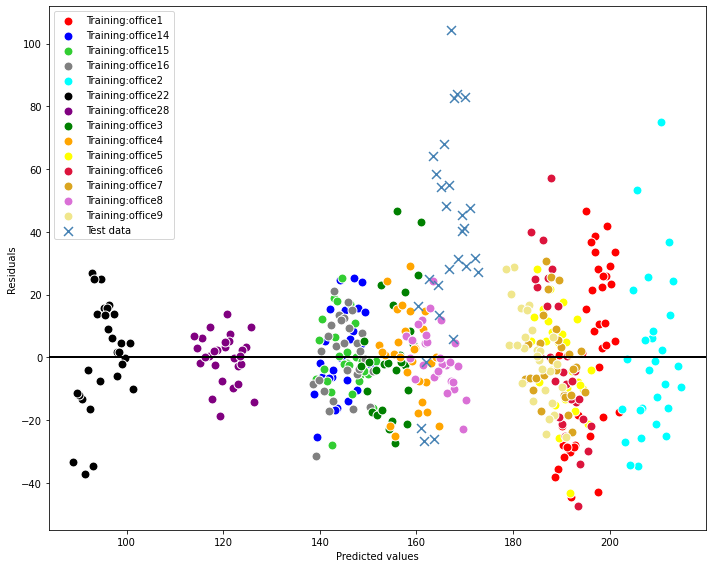

In [50]:
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()

show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy(), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy(), 
                            office_list=office_list)

### optunaと交差検証を使用したハイパーパラメータ調整（自動最適化）

In [51]:
class Objective:
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        params = {
            "alpha" : trial.suggest_loguniform("alpha", 0.0001, 10),
            "max_iter" : trial.suggest_int("max_iter", 100, 100000),
            "solver" : "auto",
            "positive" : False
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = Ridge(**params)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=True)
        
        self.bar.update(1)
        
        return scores["test_r2"].mean()

In [52]:
model_name = "Ridge"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=100
timeout=None
n_jobs=-1

try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)
    
    """
    複数の目的関数を持つときはmulti_objectiveモジュールを使用する
    複数の目的関数を最適化するのは多目的最適化と呼ばれ，専用の最適化アルゴリズムを指定する必要がある．単一目的関数の場合と比較する必要があるかもしれない．
    directionは目的関数がどうなるように最適化したいか．samplerが多目的最適化アルゴリズム．defaultはNSGAIIMultiObjectiveSampler
    """

    # study = optuna.multi_objective.create_study(directions=["maximize", "minimize"],
    #                                             sampler=optuna.multi_objective.samplers.NSGAIIMultiObjectiveSampler(seed=1), 
    #                                             storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-10-30/optuna.sqlite3


  0%|          | 0/100 [00:00<?, ?it/s]

study name: 104746


In [53]:
#探索の結果最も良かったscore
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

best score: 0.7342820362511027
best params: {'alpha': 1.5221648277755482, 'max_iter': 90556}


テストデータを用いた結果
r2 train score:0.7654918699465691
MSE train score:297.1672697685865
r2 test score:-1.5168439456085752
MSE test score:2451.6947199154197


/mnt/MachineLearning/modules/show_mod.py:88: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


<Figure size 720x576 with 0 Axes>

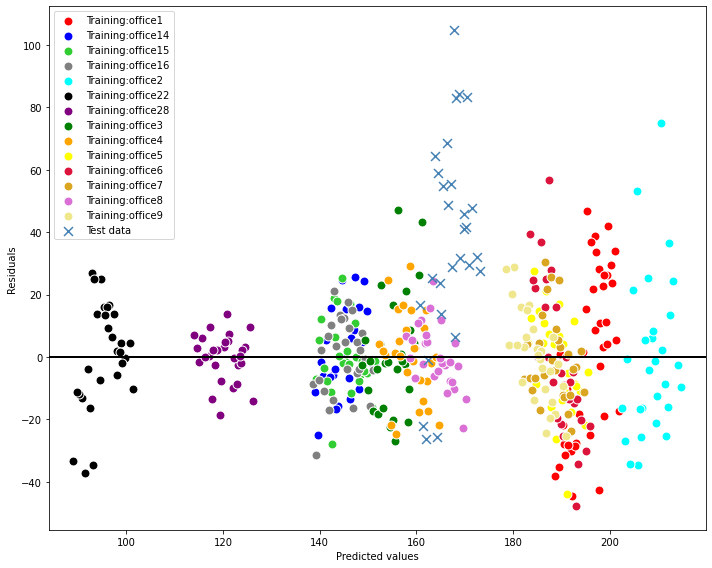

In [54]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = Ridge(alpha=study.best_params["alpha"], max_iter=study.best_params["max_iter"])
best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")


#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy(), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy(), 
                            office_list=office_list)

## ElasticNet

In [ ]:
#エラスティックネットのインスタンス作成
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)）

In [ ]:
#k分割交差検証の実装
#評価指標の決定
metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
#交差検証の分割方法を決定
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
scores = cross_validate(estimator=elasticnet_model, scoring=metrics,
                         X=train_explanatory_variable, y=train_objective_variable, 
                         cv=kf, n_jobs=1, verbose=1, return_train_score=True)
pprint.pprint(scores)

In [ ]:
print("交差検証結果の平均値")
print("test_r2 score:", scores["test_r2"].mean())
print("test_neg_mean_squared_error:", scores["test_neg_mean_squared_error"].mean())
print("test_neg_mean_absolute_error:", scores["test_neg_mean_absolute_error"].mean())

In [ ]:
elasticnet_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = elasticnet_model.predict(train_explanatory_variable)
test_pred = elasticnet_model.predict(test_explanatory_variable)

In [ ]:
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()

show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().reshape(-1), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy().reshape(-1), 
                            office_list=office_list)

# 多項式回帰

## 多項式線形重回帰

In [38]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)
train_explanatory_variable
# train_objective_variable
# test_objective_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office2_360_82_aout,-0.385821,-0.689460,0.228419,-1.347468,0.042324,0.920106,-0.383869,0.316808,1.066746,1.169501,...,2.149953,-1.325558,-0.487173,1.441573,-1.325558,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office5_0_82_aout,-1.384552,-0.689460,0.440009,0.726539,0.042324,-0.707511,0.613681,-0.552901,-1.280259,-1.323330,...,-0.629146,-0.325005,0.546527,-0.361482,-0.325005,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office2_360_82_bout,-0.385821,-0.689460,0.228419,-1.347468,0.042324,0.920106,-0.383869,0.316808,1.066746,1.169501,...,2.149953,-1.325558,-0.487173,1.441573,-1.325558,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office1_0_123_bout,-1.384552,-0.200715,0.734172,-0.525946,1.115353,-0.268377,0.117893,1.186516,-0.923106,0.291383,...,-0.650048,-0.325005,-0.453220,-0.385536,-0.325005,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office16_960_82_bout,1.278731,-0.689460,2.269493,-0.234148,1.115353,2.128733,0.506160,1.186516,1.100760,0.568459,...,-0.378325,-0.325005,0.697432,-0.072839,-0.325005,1.194802,-0.491116,-0.871311,1.147695,-0.398249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office28_960_164_aout,1.278731,0.288031,-1.069509,0.946509,-1.030706,-0.554418,-0.264402,-0.552901,0.808235,0.018570,...,2.292085,1.676099,-0.389085,3.000243,1.676099,1.560022,0.835974,1.147695,-0.871311,-0.398249
office5_360_164_aout,-0.385821,0.288031,0.440009,0.726539,0.042324,-0.707511,0.613681,-0.552901,-1.280259,-1.323330,...,-0.629146,-0.325005,0.546527,-0.361482,-0.325005,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office6_0_164_bout,-1.384552,0.288031,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office28_360_164_bout,-0.385821,0.288031,-1.069509,0.946509,-1.030706,-0.554418,-0.264402,-0.552901,0.808235,0.018570,...,2.292085,1.676099,-0.389085,3.000243,1.676099,1.560022,0.835974,-0.871311,1.147695,-0.398249


In [32]:
#パイプラインの構築，attributeにアクセスできなくなったりするので使わない．やっぱ使う
def PolynomialRegression(n_components, degree, **kwargs):
    return make_pipeline(PCA(n_components=n_components), preprocessing.PolynomialFeatures(degree=degree), LinearRegression(**kwargs))

In [33]:
#各主成分の分散説明率
pca = PCA(n_components=None)
pca.fit(train_explanatory_variable)
pca.explained_variance_ratio_

array([1.85283702e-01, 1.67097783e-01, 1.20662430e-01, 9.90240678e-02,
       9.00084025e-02, 8.31067121e-02, 7.84434388e-02, 4.53754360e-02,
       4.33355078e-02, 2.60566278e-02, 1.97961278e-02, 1.64478163e-02,
       1.17383794e-02, 5.87392299e-03, 3.97989728e-03, 2.58669781e-03,
       1.18304975e-03, 1.02029818e-32, 2.31855587e-33, 2.01611454e-33,
       9.49783799e-34, 4.97844882e-35])

メモ：\
説明変数の数が22個もある．このまま多項式化しようとすると，項数が多すぎてメモリエラーとなり実行できない．（いけてdegree=5くらい）\
そのため説明変数を主成分分析によって減らした後，多項式回帰を実装してみようと思う．\
分散説明率の値からデータに大きく寄与しているのは大体11個位の成分なのでn_components=11でやってみる\
多項式回帰において交互作用項を考える必要があるのか？考えなければ交互作用項の数が莫大になることもない．

In [34]:
#多項式化したときの大きさを確認
degree = 10
poly_model = preprocessing.PolynomialFeatures(degree=degree)
train_explanatory_variable_pca_poly = poly_model.fit_transform(train_explanatory_variable_pca)
train_explanatory_variable_pca_poly.shape

NameError: name 'train_explanatory_variable_pca' is not defined

In [ ]:
#多項式化したときの項を確認
poly_model.get_feature_names(train_explanatory_variable.columns)

In [175]:
pca = PCA(n_components=11)
pca.fit(train_explanatory_variable)
train_explanatory_variable_pca = pd.DataFrame(pca.transform(train_explanatory_variable))

In [249]:
class Objective:
    def __init__(self, X, y, n_trials):
        #oputunaの最適化実行時に元データをそのまま参照しているとメモリの開放ができない
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        n_components = trial.suggest_int("n_components", 1, 11)
        degree = trial.suggest_int("degree", 1, 4)#*argsにはiterableオブジェクトつまり，繰り返しができるtupleの形で与える必要がある
#         kwargs = {
#         }

        model = PolynomialRegression(n_components=n_components, degree=degree)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office2", "office3", "office4", "office7", "office9", "office14", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index]
            validate_objective_variable = self.y.iloc[validate_data_index]

            #評価指標の決定，k分割交差検証の実装
            model.fit(X=train_explanatory_variable, y=train_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            #決定係数の計算
            scores.append(r2_score(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        return statistics.mean(scores)

In [176]:
class Objective:
    def __init__(self, X, y, n_trials):
        #oputunaの最適化実行時に元データをそのまま参照しているとメモリの開放ができない
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        n_components = trial.suggest_int("n_components", 1, 11)
        degree = trial.suggest_int("degree", 1, 4)#*argsにはiterableオブジェクトつまり，繰り返しができるtupleの形で与える必要がある
#         kwargs = {
#         }

        model = PolynomialRegression(n_components=n_components, degree=degree)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=False)
        
        self.bar.update(1)
        
        return scores["test_r2"].mean()

In [ ]:
model_name = "Poly_linear"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=100
timeout=None
n_jobs=-1

try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)
    
    """
    複数の目的関数を持つときはmulti_objectiveモジュールを使用する
    複数の目的関数を最適化するのは多目的最適化と呼ばれ，専用の最適化アルゴリズムを指定する必要がある．単一目的関数の場合と比較する必要があるかもしれない．
    directionは目的関数がどうなるように最適化したいか．samplerが多目的最適化アルゴリズム．defaultはNSGAIIMultiObjectiveSampler
    """

    # study = optuna.multi_objective.create_study(directions=["maximize", "minimize"],
    #                                             sampler=optuna.multi_objective.samplers.NSGAIIMultiObjectiveSampler(seed=1), 
    #                                             storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

In [250]:
#探索の結果最も良かったscore
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 0.59818626880301
best params: {'degree': 4, 'n_components': 10}


テストデータを用いた結果
r2 train score:0.8933895019260832
MSE train score:135.09617186438996
r2 test score:-5.627731650287864e+24
MSE test score:5.482056206220367e+27


/mnt/MachineLearning/modules/show_mod.py:86: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


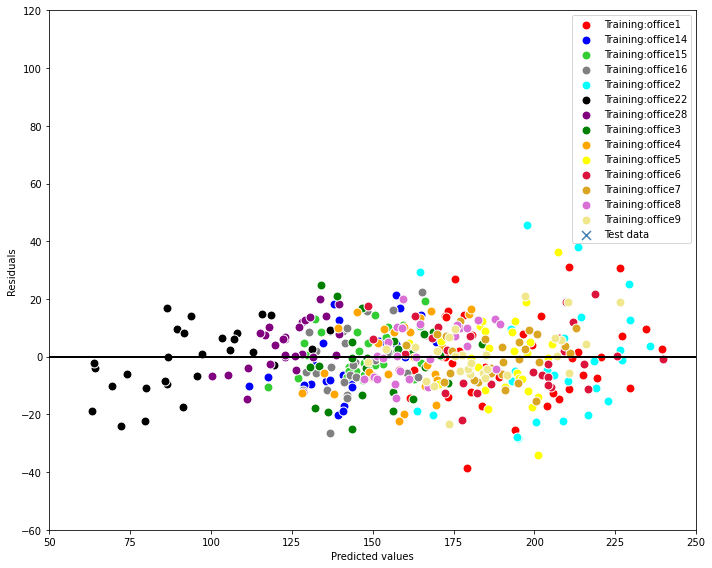

In [35]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = PolynomialRegression(n_components=study.best_params["n_components"], degree=study.best_params["degree"])
best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")


#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy(), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy(), 
                            office_list=office_list)

超過学習．テストデータには一切適応できず．\
データ数を増やす，同じオフィス形状だけで試すなどすれば改善する可能性あり

## Lasso

In [137]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)
train_explanatory_variable
# train_objective_variable
# test_objective_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office2_360_82_aout,-0.385821,-0.689460,0.228419,-1.347468,0.042324,0.920106,-0.383869,0.316808,1.066746,1.169501,...,2.149953,-1.325558,-0.487173,1.441573,-1.325558,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office5_0_82_aout,-1.384552,-0.689460,0.440009,0.726539,0.042324,-0.707511,0.613681,-0.552901,-1.280259,-1.323330,...,-0.629146,-0.325005,0.546527,-0.361482,-0.325005,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office2_360_82_bout,-0.385821,-0.689460,0.228419,-1.347468,0.042324,0.920106,-0.383869,0.316808,1.066746,1.169501,...,2.149953,-1.325558,-0.487173,1.441573,-1.325558,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office1_0_123_bout,-1.384552,-0.200715,0.734172,-0.525946,1.115353,-0.268377,0.117893,1.186516,-0.923106,0.291383,...,-0.650048,-0.325005,-0.453220,-0.385536,-0.325005,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office16_960_82_bout,1.278731,-0.689460,2.269493,-0.234148,1.115353,2.128733,0.506160,1.186516,1.100760,0.568459,...,-0.378325,-0.325005,0.697432,-0.072839,-0.325005,1.194802,-0.491116,-0.871311,1.147695,-0.398249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office28_960_164_aout,1.278731,0.288031,-1.069509,0.946509,-1.030706,-0.554418,-0.264402,-0.552901,0.808235,0.018570,...,2.292085,1.676099,-0.389085,3.000243,1.676099,1.560022,0.835974,1.147695,-0.871311,-0.398249
office5_360_164_aout,-0.385821,0.288031,0.440009,0.726539,0.042324,-0.707511,0.613681,-0.552901,-1.280259,-1.323330,...,-0.629146,-0.325005,0.546527,-0.361482,-0.325005,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office6_0_164_bout,-1.384552,0.288031,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office28_360_164_bout,-0.385821,0.288031,-1.069509,0.946509,-1.030706,-0.554418,-0.264402,-0.552901,0.808235,0.018570,...,2.292085,1.676099,-0.389085,3.000243,1.676099,1.560022,0.835974,-0.871311,1.147695,-0.398249


In [138]:
#パイプラインの構築
def LassoRegression(n_components, degree, **kwargs):
    return make_pipeline(PCA(n_components=n_components), preprocessing.PolynomialFeatures(degree=degree), Lasso(**kwargs))

In [139]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        #クラスにしとくとX,yをインスタンス変数にできるので，メモリを圧迫しないような気がする
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        n_components = trial.suggest_int("n_components", 1, 11)
        degree = trial.suggest_int("degree", 1, 5)
        kwargs = {
            "alpha" : trial.suggest_loguniform("alpha", 0.0001, 10),
            "max_iter" : trial.suggest_int("max_iter", 1000, 100000)
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = LassoRegression(n_components=n_components, degree=degree, **kwargs)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office2", "office3", "office4", "office7", "office9", "office14", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index]
            validate_objective_variable = self.y.iloc[validate_data_index]

            #評価指標の決定，k分割交差検証の実装
            model.fit(X=train_explanatory_variable, y=train_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            #決定係数の計算
            scores.append(r2_score(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [140]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        #クラスにしとくとX,yをインスタンス変数にできるので，メモリを圧迫しないような気がする
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        n_components = trial.suggest_int("n_components", 1, 11)
        degree = trial.suggest_int("degree", 1, 5)
        kwargs = {
            "alpha" : trial.suggest_loguniform("alpha", 0.0001, 10),
            "max_iter" : trial.suggest_int("max_iter", 1000, 100000)
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = LassoRegression(n_components=n_components, degree=degree, **kwargs)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=False)
        
        self.bar.update(1)
        
        return scores["test_r2"].mean()

In [141]:
model_name = "Poly_Lasso"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=100
timeout=None
n_jobs=-1

try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)
    
    """
    複数の目的関数を持つときはmulti_objectiveモジュールを使用する
    複数の目的関数を最適化するのは多目的最適化と呼ばれ，専用の最適化アルゴリズムを指定する必要がある．単一目的関数の場合と比較する必要があるかもしれない．
    directionは目的関数がどうなるように最適化したいか．samplerが多目的最適化アルゴリズム．defaultはNSGAIIMultiObjectiveSampler
    """

    # study = optuna.multi_objective.create_study(directions=["maximize", "minimize"],
    #                                             sampler=optuna.multi_objective.samplers.NSGAIIMultiObjectiveSampler(seed=1), 
    #                                             storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-11-24/optuna.sqlite3


  0%|          | 0/100 [00:00<?, ?it/s]

study name: 84428


In [142]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 0.8059950494572334
best params: {'alpha': 0.22745099553950932, 'degree': 3, 'max_iter': 91820, 'n_components': 10}


テストデータを用いた結果
r2 train score:0.8825328683796231
MSE train score:148.85363157013464
r2 test score:-1.4750694294682063
MSE test score:2411.0015490785604


/mnt/MachineLearning/modules/show_mod.py:86: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


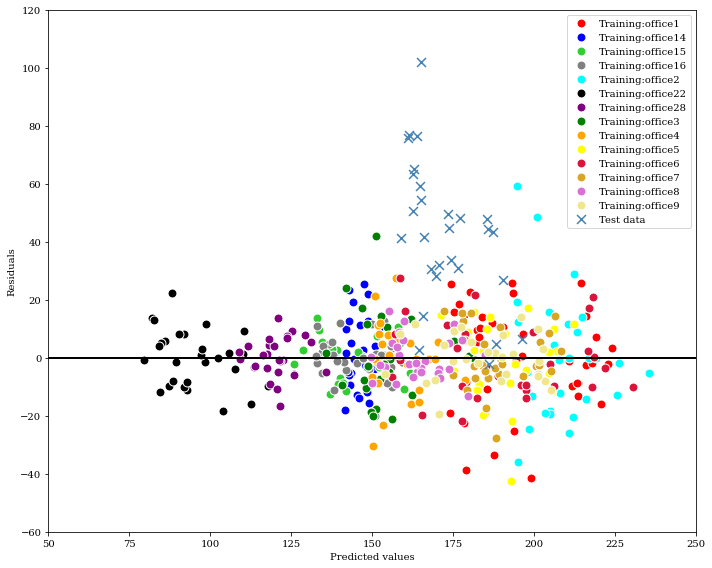

In [143]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = LassoRegression(n_components=study.best_params["n_components"], degree=study.best_params["degree"], 
                             alpha=study.best_params["alpha"], max_iter=study.best_params["max_iter"])
best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")


#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().reshape(-1), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy().reshape(-1), 
                            office_list=office_list)

トレーニングデータに関するフィッティングはかなり良くなっている\
しかしテストデータに関してはまだ厳しい

## Ridge

In [41]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)
train_explanatory_variable
# train_objective_variable
# test_objective_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office2_360_82_aout,-0.385821,-0.689460,0.228419,-1.347468,0.042324,0.920106,-0.383869,0.316808,1.066746,1.169501,...,2.149953,-1.325558,-0.487173,1.441573,-1.325558,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office5_0_82_aout,-1.384552,-0.689460,0.440009,0.726539,0.042324,-0.707511,0.613681,-0.552901,-1.280259,-1.323330,...,-0.629146,-0.325005,0.546527,-0.361482,-0.325005,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office2_360_82_bout,-0.385821,-0.689460,0.228419,-1.347468,0.042324,0.920106,-0.383869,0.316808,1.066746,1.169501,...,2.149953,-1.325558,-0.487173,1.441573,-1.325558,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office1_0_123_bout,-1.384552,-0.200715,0.734172,-0.525946,1.115353,-0.268377,0.117893,1.186516,-0.923106,0.291383,...,-0.650048,-0.325005,-0.453220,-0.385536,-0.325005,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office16_960_82_bout,1.278731,-0.689460,2.269493,-0.234148,1.115353,2.128733,0.506160,1.186516,1.100760,0.568459,...,-0.378325,-0.325005,0.697432,-0.072839,-0.325005,1.194802,-0.491116,-0.871311,1.147695,-0.398249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office28_960_164_aout,1.278731,0.288031,-1.069509,0.946509,-1.030706,-0.554418,-0.264402,-0.552901,0.808235,0.018570,...,2.292085,1.676099,-0.389085,3.000243,1.676099,1.560022,0.835974,1.147695,-0.871311,-0.398249
office5_360_164_aout,-0.385821,0.288031,0.440009,0.726539,0.042324,-0.707511,0.613681,-0.552901,-1.280259,-1.323330,...,-0.629146,-0.325005,0.546527,-0.361482,-0.325005,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office6_0_164_bout,-1.384552,0.288031,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office28_360_164_bout,-0.385821,0.288031,-1.069509,0.946509,-1.030706,-0.554418,-0.264402,-0.552901,0.808235,0.018570,...,2.292085,1.676099,-0.389085,3.000243,1.676099,1.560022,0.835974,-0.871311,1.147695,-0.398249


In [42]:
#パイプラインの構築
def RidgeRegression(n_components, degree, **kwargs):
    return make_pipeline(PCA(n_components=n_components), preprocessing.PolynomialFeatures(degree=degree), Ridge(**kwargs))

In [44]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        n_components = trial.suggest_int("n_components", 1, 11)
        degree = trial.suggest_int("degree", 1, 5)
        kwargs = {
            "alpha" : trial.suggest_loguniform("alpha", 0.0001, 10),
            "max_iter" : trial.suggest_int("max_iter", 1000, 100000),
            "solver" : "auto",
            "positive" : False
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = RidgeRegression(n_components=n_components, degree=degree, **kwargs)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office2", "office3", "office4", "office7", "office9", "office14", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index]
            validate_objective_variable = self.y.iloc[validate_data_index]

            #評価指標の決定，k分割交差検証の実装
            model.fit(X=train_explanatory_variable, y=train_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            #決定係数の計算
            scores.append(r2_score(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [ ]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        n_components = trial.suggest_int("n_components", 1, 11)
        degree = trial.suggest_int("degree", 1, 5)
        kwargs = {
            "alpha" : trial.suggest_loguniform("alpha", 0.0001, 10),
            "max_iter" : trial.suggest_int("max_iter", 1000, 100000),
            "solver" : "auto",
            "positive" : False
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = RidgeRegression(n_components=n_components, degree=degree, **kwargs)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=False)
        
        self.bar.update(1)
        
        return scores["test_r2"].mean()

In [45]:
model_name = "Poly_Ridge"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=100
timeout=None
n_jobs=-1

try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)
    
    """
    複数の目的関数を持つときはmulti_objectiveモジュールを使用する
    複数の目的関数を最適化するのは多目的最適化と呼ばれ，専用の最適化アルゴリズムを指定する必要がある．単一目的関数の場合と比較する必要があるかもしれない．
    directionは目的関数がどうなるように最適化したいか．samplerが多目的最適化アルゴリズム．defaultはNSGAIIMultiObjectiveSampler
    """

    # study = optuna.multi_objective.create_study(directions=["maximize", "minimize"],
    #                                             sampler=optuna.multi_objective.samplers.NSGAIIMultiObjectiveSampler(seed=1), 
    #                                             storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-11-10/optuna.sqlite3


  0%|          | 0/100 [00:00<?, ?it/s]

study name: 134851


In [46]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 0.6323021581441557
best params: {'alpha': 5.894679291585266, 'degree': 5, 'max_iter': 83319, 'n_components': 8}


テストデータを用いた結果
r2 train score:0.9477819055511764
MSE train score:66.17045027965362
r2 test score:-2.9012218201856355
MSE test score:3800.237577087925


/mnt/MachineLearning/modules/show_mod.py:86: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


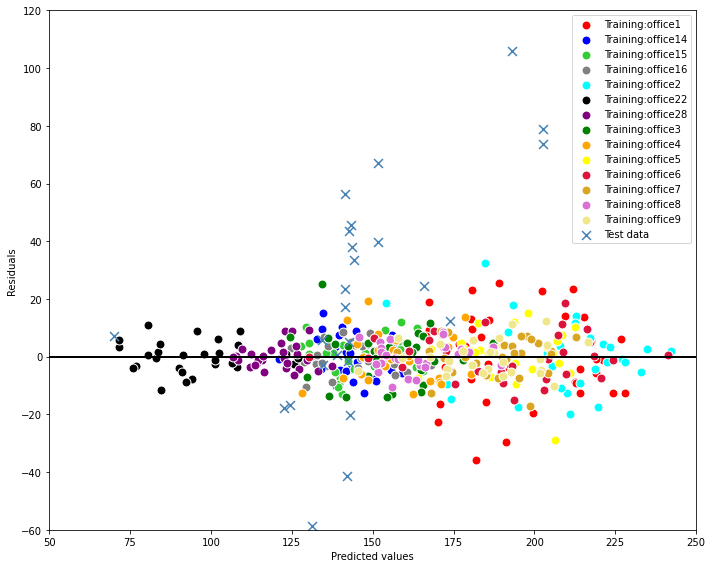

In [47]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = RidgeRegression(n_components=study.best_params["n_components"], degree=study.best_params["degree"], 
                             alpha=study.best_params["alpha"], max_iter=study.best_params["max_iter"])
best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")


#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy(), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy(), 
                            office_list=office_list)

## ElasticNet

In [48]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)
train_explanatory_variable
# train_objective_variable
# test_objective_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office2_360_82_aout,-0.385821,-0.689460,0.228419,-1.347468,0.042324,0.920106,-0.383869,0.316808,1.066746,1.169501,...,2.149953,-1.325558,-0.487173,1.441573,-1.325558,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office5_0_82_aout,-1.384552,-0.689460,0.440009,0.726539,0.042324,-0.707511,0.613681,-0.552901,-1.280259,-1.323330,...,-0.629146,-0.325005,0.546527,-0.361482,-0.325005,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office2_360_82_bout,-0.385821,-0.689460,0.228419,-1.347468,0.042324,0.920106,-0.383869,0.316808,1.066746,1.169501,...,2.149953,-1.325558,-0.487173,1.441573,-1.325558,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office1_0_123_bout,-1.384552,-0.200715,0.734172,-0.525946,1.115353,-0.268377,0.117893,1.186516,-0.923106,0.291383,...,-0.650048,-0.325005,-0.453220,-0.385536,-0.325005,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office16_960_82_bout,1.278731,-0.689460,2.269493,-0.234148,1.115353,2.128733,0.506160,1.186516,1.100760,0.568459,...,-0.378325,-0.325005,0.697432,-0.072839,-0.325005,1.194802,-0.491116,-0.871311,1.147695,-0.398249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office28_960_164_aout,1.278731,0.288031,-1.069509,0.946509,-1.030706,-0.554418,-0.264402,-0.552901,0.808235,0.018570,...,2.292085,1.676099,-0.389085,3.000243,1.676099,1.560022,0.835974,1.147695,-0.871311,-0.398249
office5_360_164_aout,-0.385821,0.288031,0.440009,0.726539,0.042324,-0.707511,0.613681,-0.552901,-1.280259,-1.323330,...,-0.629146,-0.325005,0.546527,-0.361482,-0.325005,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office6_0_164_bout,-1.384552,0.288031,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office28_360_164_bout,-0.385821,0.288031,-1.069509,0.946509,-1.030706,-0.554418,-0.264402,-0.552901,0.808235,0.018570,...,2.292085,1.676099,-0.389085,3.000243,1.676099,1.560022,0.835974,-0.871311,1.147695,-0.398249


In [49]:
#パイプラインの構築
def ElasticNetRegression(n_components, degree, **kwargs):
    return make_pipeline(PCA(n_components=n_components), preprocessing.PolynomialFeatures(degree=degree), ElasticNet(**kwargs))

In [266]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        n_components = trial.suggest_int("n_components", 1, 11)
        degree = trial.suggest_int("degree", 1, 5)
        kwargs = {
            "alpha" : trial.suggest_loguniform("alpha", 0.0001, 10),
            "l1_ratio" : trial.suggest_float("l1_ratio", 0, 1),
            "max_iter" : trial.suggest_int("max_iter", 1000, 100000),
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = ElasticNetRegression(n_components=n_components, degree=degree, **kwargs)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office2", "office3", "office4", "office7", "office9", "office14", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index]
            validate_objective_variable = self.y.iloc[validate_data_index]

            #評価指標の決定，k分割交差検証の実装
            model.fit(X=train_explanatory_variable, y=train_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            #決定係数の計算
            scores.append(r2_score(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [159]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        n_components = trial.suggest_int("n_components", 1, 11)
        degree = trial.suggest_int("degree", 1, 5)
        kwargs = {
            "alpha" : trial.suggest_loguniform("alpha", 0.0001, 10),
            "l1_ratio" : trial.suggest_float("l1_ratio", 0, 1),
            "max_iter" : trial.suggest_int("max_iter", 1000, 100000),
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = ElasticNetRegression(n_components=n_components, degree=degree, **kwargs)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=False)
        
        self.bar.update(1)
        
        return scores["test_r2"].mean()

In [268]:
model_name = "Poly_ElasticNet"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=1000
timeout=None
n_jobs=-1

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-11-09/optuna.sqlite3


  0%|          | 0/1000 [00:00<?, ?it/s]

study name: 104731


In [269]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 0.6572892618725588
best params: {'alpha': 0.2294328398907448, 'degree': 5, 'l1_ratio': 0.1039310608295505, 'max_iter': 61104, 'n_components': 11}


テストデータを用いた結果
r2 train score:0.9447203971897449
MSE train score:70.04997497217923
r2 test score:-0.8706228645590304
MSE test score:1822.2012564563215


/mnt/MachineLearning/modules/show_mod.py:86: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


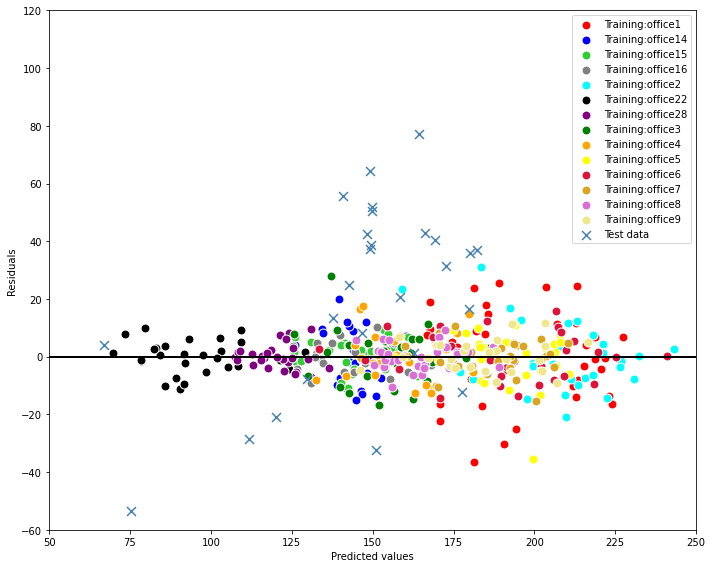

In [50]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

# best_model = ElasticNetRegression(n_components=study.best_params["n_components"], degree=study.best_params["degree"], 
#                              alpha=study.best_params["alpha"], l1_ratio=study.best_params["l1_ratio"], max_iter=study.best_params["max_iter"])
best_model = ElasticNetRegression(n_components=11, degree=5, 
                             alpha=0.2294328398907448, l1_ratio=0.1039310608295505, max_iter=61104)
best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")


#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().reshape(-1), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy().reshape(-1), 
                            office_list=office_list)

# サポートベクター回帰

サポートベクターマシンの考え方は，カーネル法を用いてデータセットを高次元に写像し，線形分離可能にするというものである．\
これの何がいいかというと，元の次元では非線形分離できるのに，高次元空間では線形分離しているので，多項式回帰と比較して\
汎化性能が高い．\
カーネル法を用いると特徴量が何であるかが分からなくなるため，特徴量との相関よりも，精度が要求されるときに使用する．

In [51]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)

#SVRはyの形状が一次元じゃないとDataConversionWarningを出してくる
test_objective_variable = test_objective_variable.to_numpy().flatten()

test_explanatory_variable
test_objective_variable

array([ 62.96190476, 151.25238095, 140.32857143, 141.27142857,
       123.57619048, 117.77619048, 141.18095238, 137.48095238,
       137.67142857,  84.56190476, 111.78571429, 128.9       ,
       143.98571429, 183.47142857, 188.23333333,  85.16190476,
       138.5952381 , 124.2047619 , 110.7047619 ,  97.74761905,
       189.77619048, 145.46190476, 128.59047619, 161.51904762,
        87.10952381,  99.41904762, 105.51428571, 163.34285714])

In [52]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        kwargs = {
            "kernel" : trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]), 
            "epsilon" : trial.suggest_float("epsilon", 0, 1), 
            "degree" : trial.suggest_int("degree", 2, 6), 
            "C" : trial.suggest_loguniform("C", 0.0001, 10)
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = SVR(**kwargs)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office2", "office3", "office4", "office7", "office9", "office14", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            #SVRはyの形状が一次元じゃないとDataConversionWarningを出してくる
            train_objective_variable = self.y.iloc[train_data_index].to_numpy().flatten()
            validate_objective_variable = self.y.iloc[validate_data_index].to_numpy().flatten()

            #評価指標の決定，k分割交差検証の実装
            model.fit(X=train_explanatory_variable, y=train_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            #決定係数の計算
            scores.append(r2_score(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [ ]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        kwargs = {
            "kernel" : trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]), 
            "epsilon" : trial.suggest_float("epsilon", 0, 1), 
            "degree" : trial.suggest_int("degree", 2, 6), 
            "C" : trial.suggest_loguniform("C", 0.0001, 10)
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = SVR(**kwargs)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=False)
        
        self.bar.update(1)
        
        return scores["test_r2"].mean()

In [53]:
model_name = "SVR"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=200
timeout=None
n_jobs=-1

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-11-10/optuna.sqlite3


  0%|          | 0/200 [00:00<?, ?it/s]

study name: 14125


In [54]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 0.05531934963934123
best params: {'C': 8.325987397956395, 'degree': 4, 'epsilon': 0.5014416364910296, 'kernel': 'rbf'}


In [ ]:
#最適化結果の一覧表示
for i in study.trials:
    print(i.number, i.params, i.value)

In [77]:
#最適化結果のパラメータを一覧取得
params = [d.params for d in study.trials]
use_params = params[123]
use_params

{'kernel': 'sigmoid',
 'epsilon': 0.1643070715059598,
 'degree': 2,
 'C': 2.296676964808915}

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/MachineLearning/modules/show_mod.py:86: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


テストデータを用いた結果
r2 train score:0.7773620831428952
MSE train score:282.1254081225977
r2 test score:-1.6949933362421028
MSE test score:2625.2326625973437


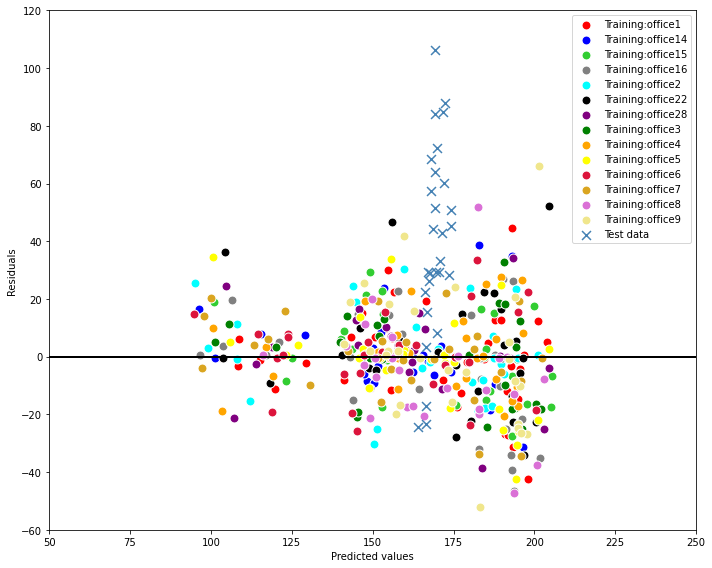

In [55]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = SVR(kernel=study.best_params["kernel"], epsilon=study.best_params["epsilon"], 
                 C=study.best_params["C"], degree=study.best_params["degree"])

#最適化結果から使ってみたいパラメータを選んでみた
# best_model = SVR(kernel=use_params["kernel"], epsilon=use_params["epsilon"], 
#                  C=use_params["C"], degree=use_params["degree"])

best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")

#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_objective_variable.iloc[train_data_index].index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().flatten(), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable, 
                            office_list=office_list)

# 決定木回帰

決定木のアルゴリズムは説明変数を標準化する必要はない．\
しかし主成分分析と組み合わせるときは標準化必須．

In [56]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)
train_explanatory_variable
# train_objective_variable
# test_objective_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office2_360_82_aout,360,82,3.780,1.265,90.0,4.760,2.740,180.0,4.760,4.190,...,4.590,0.0,2.840,3.140,0.0,6.0,5.5,1,0,0
office5_0_82_aout,0,82,4.190,3.575,90.0,2.740,3.575,90.0,1.310,1.266,...,1.266,90.0,4.210,1.266,90.0,6.0,5.5,1,0,0
office2_360_82_bout,360,82,3.780,1.265,90.0,4.760,2.740,180.0,4.760,4.190,...,4.590,0.0,2.840,3.140,0.0,6.0,5.5,0,1,0
office1_0_123_bout,0,123,4.760,2.180,180.0,3.285,3.160,270.0,1.835,3.160,...,1.241,90.0,2.885,1.241,90.0,6.0,5.5,0,1,0
office16_960_82_bout,960,82,7.735,2.505,180.0,6.260,3.485,270.0,4.810,3.485,...,1.566,90.0,4.410,1.566,90.0,9.0,5.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office28_960_164_aout,960,164,1.265,3.820,0.0,2.930,2.840,90.0,4.380,2.840,...,4.760,270.0,2.970,4.760,270.0,9.5,6.0,1,0,0
office5_360_164_aout,360,164,4.190,3.575,90.0,2.740,3.575,90.0,1.310,1.266,...,1.266,90.0,4.210,1.266,90.0,6.0,5.5,1,0,0
office6_0_164_bout,0,164,4.734,0.810,180.0,4.734,2.260,180.0,4.734,3.710,...,2.260,180.0,2.984,0.810,180.0,6.0,5.5,0,1,0
office28_360_164_bout,360,164,1.265,3.820,0.0,2.930,2.840,90.0,4.380,2.840,...,4.760,270.0,2.970,4.760,270.0,9.5,6.0,0,1,0


In [165]:
#パイプラインの構築
def PCADecisionTreeRegressor(n_components, **kwargs):
    return make_pipeline(PCA(n_components=n_components), DecisionTreeRegressor(**kwargs))

In [279]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
#         n_components = trial.suggest_int("n_components", 1, 11)
        kwargs = {
            "criterion" : "squared_error", 
            "max_depth" : trial.suggest_int("max_depth", 2, 200), 
        }
        
        #ただの決定木回帰
        model = DecisionTreeRegressor(**kwargs)
        #PCAと決定木回帰を組み合わせてみる
#         model = PCADecisionTreeRegressor(n_components=n_components, **kwargs)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office2", "office3", "office4", "office7", "office9", "office14", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index]
            validate_objective_variable = self.y.iloc[validate_data_index]

            #評価指標の決定，k分割交差検証の実装
            model.fit(X=train_explanatory_variable, y=train_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            #決定係数の計算
            scores.append(r2_score(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [168]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
#         n_components = trial.suggest_int("n_components", 1, 11)
        kwargs = {
            "criterion" : "squared_error", 
            "max_depth" : trial.suggest_int("max_depth", 2, 200), 
        }
        
        #ただの決定木回帰
        model = DecisionTreeRegressor(**kwargs)
        #PCAと決定木回帰を組み合わせてみる
#         model = PCADecisionTreeRegressor(n_components=n_components, **kwargs)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=False)
        
        self.bar.update(1)
        
        return scores["test_r2"].mean()

In [280]:
model_name = "DecisionTreeRegressor"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=200
timeout=None
n_jobs=-1

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-11-09/optuna.sqlite3


  0%|          | 0/200 [00:00<?, ?it/s]

study name: 173819


In [281]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 0.8576682943445129
best params: {'max_depth': 42}


テストデータを用いた結果
r2 train score:1.0
MSE train score:0.0
r2 test score:-0.42574867063976707
MSE test score:1388.8427583414316


/mnt/MachineLearning/modules/show_mod.py:86: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


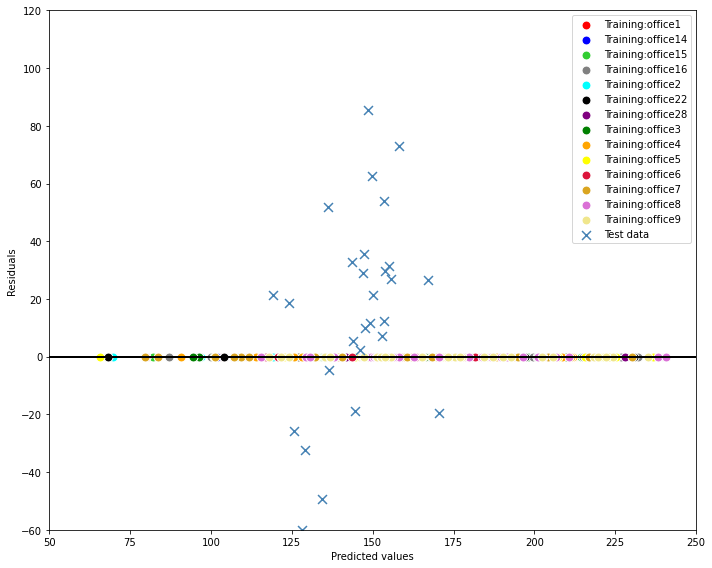

In [57]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = DecisionTreeRegressor(max_depth=study.best_params["max_depth"])
# best_model = PCADecisionTreeRegressor(n_components=study.best_params["n_components"], max_depth=study.best_params["max_depth"])

#最適化結果から使ってみたいパラメータを選んでみた
# best_model = SVR(kernel=use_params["kernel"], epsilon=use_params["epsilon"], 
#                  C=use_params["C"], degree=use_params["degree"])

best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")

#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_objective_variable.iloc[train_data_index].index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().reshape(-1), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy().reshape(-1), 
                            office_list=office_list)

メモ：
やってみた感じ一番うまく回帰できてる．予測できているとは言えない．\
また主成分分析と組み合わせてみたが，そんなことはせず説明変数全て使って回帰したほうが精度は良かった\
決定木回帰は分類されたデータ群の平均値を予測値とするため，予測値は離散的になる．\
しかし決定木の深さが4程度でデータを上手く予測できるというのはなにか怪しい気がする．\
また**次元の呪い**的にも決定木のアルゴリズムにおいて特徴量が多すぎるのはあまり好ましくない気がするが，20くらいの特徴量なら許容できるのか？

## ランダムフォレスト回帰

ランダムフォレストは決定木を複数組み合わせたモデルである．\
このように複数のモデルを組み合わせることをアンサンブル手法という

In [58]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)

#ランダムフォレストはyの形状が一次元じゃないとDataConversionWarningを出してくる
test_objective_variable = test_objective_variable.to_numpy().flatten()

test_explanatory_variable
test_objective_variable

array([ 62.96190476, 151.25238095, 140.32857143, 141.27142857,
       123.57619048, 117.77619048, 141.18095238, 137.48095238,
       137.67142857,  84.56190476, 111.78571429, 128.9       ,
       143.98571429, 183.47142857, 188.23333333,  85.16190476,
       138.5952381 , 124.2047619 , 110.7047619 ,  97.74761905,
       189.77619048, 145.46190476, 128.59047619, 161.51904762,
        87.10952381,  99.41904762, 105.51428571, 163.34285714])

In [284]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        kwargs = {
            "n_estimators" : trial.suggest_int("n_estimators", 10, 1000), 
            "criterion" : "squared_error", 
            "random_state" : 1
        }
        
        #ランダムフォレスト回帰
        model = RandomForestRegressor(**kwargs)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office2", "office3", "office4", "office7", "office9", "office14", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            #SVRはyの形状が一次元じゃないとDataConversionWarningを出してくる
            train_objective_variable = self.y.iloc[train_data_index].to_numpy().flatten()
            validate_objective_variable = self.y.iloc[validate_data_index].to_numpy().flatten()

            #評価指標の決定，k分割交差検証の実装
            model.fit(X=train_explanatory_variable, y=train_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            #決定係数の計算
            scores.append(r2_score(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [ ]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        kwargs = {
            "n_estimators" : trial.suggest_int("n_estimators", 10, 1000), 
            "criterion" : "squared_error", 
            "random_state" : 1
        }
        
        #ランダムフォレスト回帰
        model = RandomForestRegressor(**kwargs)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=False)
        
        self.bar.update(1)
        
        return scores["test_r2"].mean()

他にもブートストラップ標本のサイズやランダムフォレストを構成する決定木の分割ごとに選択される特徴量の個数を最適化して調整できるらしいが\
scikitlearnではデフォルトでいい感じになっているらしい．この辺の調整は勾配ブースティング木で問題になってくる．\
ブートストラップ標本は復元抽出，分割に使用する特徴量は非復元抽出．

In [285]:
model_name = "RandomForestRegressor"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=300
timeout=None
n_jobs=-1

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-11-09/optuna.sqlite3


  0%|          | 0/300 [00:00<?, ?it/s]

study name: 174212


In [286]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 0.8067005795747889
best params: {'n_estimators': 638}


/tmp/ipykernel_75503/849524001.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model.fit(train_explanatory_variable, train_objective_variable)


テストデータを用いた結果
r2 train score:0.9726832176201772
MSE train score:34.61565975058109
r2 test score:0.07769795844258065
MSE test score:898.4279893073688


/mnt/MachineLearning/modules/show_mod.py:86: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


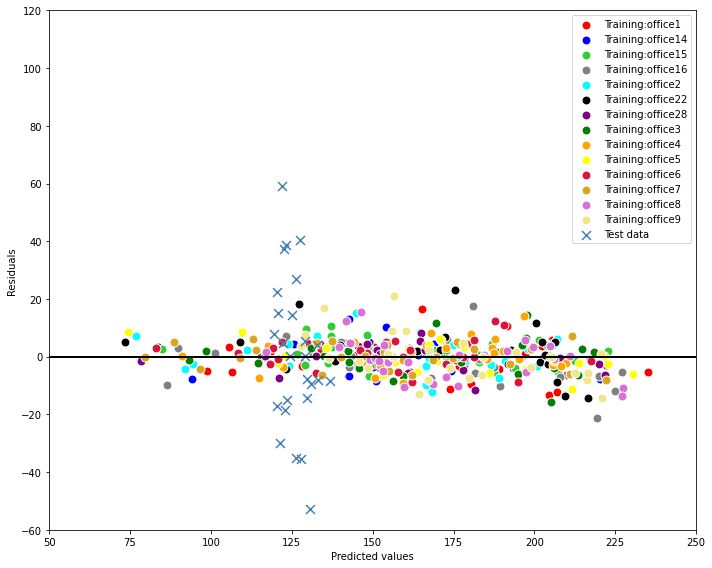

In [59]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

# best_model = RandomForestRegressor(n_estimators=study.best_params["n_estimators"])
best_model = RandomForestRegressor(n_estimators=638)


#最適化結果から使ってみたいパラメータを選んでみた
# best_model = SVR(kernel=use_params["kernel"], epsilon=use_params["epsilon"], 
#                  C=use_params["C"], degree=use_params["degree"])

best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")

#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_objective_variable.iloc[train_data_index].index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().flatten(), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable, 
                            office_list=office_list)

random forest importance
  1) office_size_y   0.4339367071044363
  2) 1_x             0.18074758433922
  3) aircon          0.09049438862350506
  4) ventilation     0.05682789316689504
  5) 3_x             0.030790409915941175
  6) 5_y             0.027437829202911584
  7) 4_x             0.02495326918738358
  8) office_size_x   0.01841619031891449
  9) exhaust_b       0.016035165202515123
 10) 1_y             0.015002658938858852
 11) exhaust_a       0.014019453389796138
 12) 3_y             0.013162105683721741
 13) 2_x             0.013129690572268454
 14) 4_y             0.010789907901341149
 15) 5_angle         0.009882703992015648
 16) 5_x             0.009765982832099916
 17) 4_angle         0.00971964620870331
 18) 2_y             0.00619306765420513
 19) 1_angle         0.0058657385094194135
 20) 2_angle         0.005809319644499839
 21) exhaust_off     0.0044418231986461726
 22) 3_angle         0.0025784644127018344


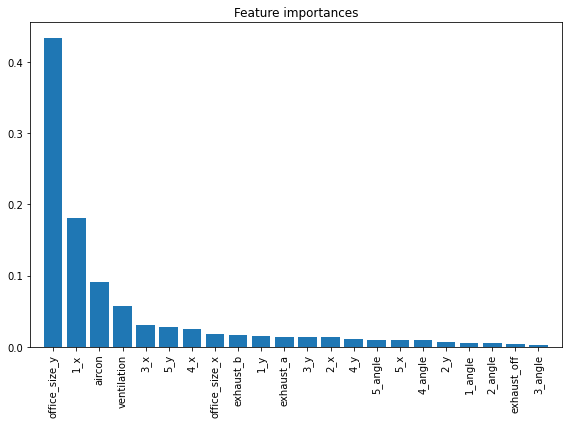

In [288]:
#ランダムフォレスト回帰から特徴量の重要度を見てみる
feature_importance = best_model.feature_importances_

#np.argsortはソートしてindexを返す．本来は昇順になるが[::-1]によって降順にする．
idx = np.argsort(feature_importance)[::-1]
feature_labels = train_explanatory_variable.columns.to_numpy()

print("random forest importance")
for i in range(train_explanatory_variable.shape[1]):
    top_cols, top_importances = feature_labels[idx[i]], feature_importance[idx[i]]
    print(f"{i+1:3}) {top_cols:15} {top_importances}")

fig= plt.figure(figsize=[8, 6])
plt.title("Feature importances")
plt.bar(range(train_explanatory_variable.shape[1]), feature_importance[idx], align="center")
plt.xticks(range(train_explanatory_variable.shape[1]), feature_labels[idx], rotation=90)
plt.xlim([-1, train_explanatory_variable.shape[1]])
plt.tight_layout()
plt.show()

メモ：\
ランダムフォレストから特徴量の重要度を見てみた（こっちの方が主成分分析の分散説明率より正しいと思う）\
office_size_yはよく効いているが，相関係数では分からなかったエアコンと，換気口の流速も結構説明変数として効いてるっぽい．\
各オフィスで別々に特徴量の重要度を見ていけば，人の位置の効き方は異なってくると考えたい．\
次元の呪いで過学習になっている気もするので，特徴量を選び直してやってみる．

In [289]:
delete_cols = ["1_angle", "2_angle", "3_angle", "4_angle", "5_angle", "exhaust_off"]
train_explanatory_variable.drop(train_explanatory_variable[delete_cols], axis=1, inplace=True)
test_explanatory_variable.drop(test_explanatory_variable[delete_cols], axis=1, inplace=True)
train_explanatory_variable

,aircon,ventilation,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,5_y,office_size_x,office_size_y,exhaust_a,exhaust_b
office2_360_82_aout,360,82,3.780,1.265,4.760,2.740,4.760,4.190,2.840,4.590,2.840,3.140,6.0,5.5,1,0
office5_0_82_aout,0,82,4.190,3.575,2.740,3.575,1.310,1.266,2.760,1.266,4.210,1.266,6.0,5.5,1,0
office2_360_82_bout,360,82,3.780,1.265,4.760,2.740,4.760,4.190,2.840,4.590,2.840,3.140,6.0,5.5,0,1
office1_0_123_bout,0,123,4.760,2.180,3.285,3.160,1.835,3.160,1.435,1.241,2.885,1.241,6.0,5.5,0,1
office16_960_82_bout,960,82,7.735,2.505,6.260,3.485,4.810,3.485,5.860,1.566,4.410,1.566,9.0,5.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office28_960_164_aout,960,164,1.265,3.820,2.930,2.840,4.380,2.840,4.420,4.760,2.970,4.760,9.5,6.0,1,0
office5_360_164_aout,360,164,4.190,3.575,2.740,3.575,1.310,1.266,2.760,1.266,4.210,1.266,6.0,5.5,1,0
office6_0_164_bout,0,164,4.734,0.810,4.734,2.260,4.734,3.710,2.984,2.260,2.984,0.810,6.0,5.5,0,1
office28_360_164_bout,360,164,1.265,3.820,2.930,2.840,4.380,2.840,4.420,4.760,2.970,4.760,9.5,6.0,0,1


## 勾配ブースティング木(GBDT)

今回は勾配ブースティング木の構築にxgboostを使ってみたが，より高速で精度は同等のlightgbmもある\
xgbには2つのAPIがあり，どちらを使うかで指定できるパラメータの名前も異なってくるので注意する\
今回はscikitlearnAPIを使用

In [60]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)

test_explanatory_variable
test_objective_variable

#xgboost専用のデータ型に変換する(xgboost専用APIのみ必要)
# xgb_train_explanatory_variable = xgb.DMatrix(train_explanatory_variable)
# xgb_test_explanatory_variable = xgb.DMatrix(test_explanatory_variable)
# xgb_train_objective_variable = xgb.DMatrix(train_objective_variable)
# xgb_test_objective_variable = xgb.DMatrix(test_objective_variable)

# xgb_test_explanatory_variable

,RoI
office10_660_0,62.961905
office10_360_0,151.252381
office10_960_246_aout,140.328571
office10_960_164_aout,141.271429
office10_960_164_bout,123.576190
office10_660_82_aout,117.776190
office10_0_246_bout,141.180952
office10_960_82_aout,137.480952
office10_0_164_bout,137.671429
office10_660_164_bout,84.561905


In [293]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        #n_estimatorsは1000で固定にしてprunerでアーリーストッピングしたい
        kwargs = {
            "max_depth" : trial.suggest_int("max_depth", 1, 10),
            "min_child_weight" : trial.suggest_int("min_child_weight", 1, 5),
            "gamma" : trial.suggest_uniform("gamma", 0, 1),
            "subsample" : trial.suggest_uniform("subsample", 0, 1),
            "colsample_bytree" : trial.suggest_uniform("colsample_bytree", 0, 1),
            "learning_rate" : trial.suggest_uniform("learning_rate", 0, 1),
            "reg_alpha" : trial.suggest_loguniform("reg_alpha", 0.0001, 10),
            "reg_lambda" : trial.suggest_loguniform("reg_lambda", 0.0001, 10),
            "n_estimators" : 1000,
            "booster" : "gbtree",
            "objective" : "reg:squarederror",
            "random_state" : 1,
            "eval_metric" : mean_squared_error
        }
        
        #xgboost
        model = xgb.XGBRegressor(**kwargs)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office2", "office3", "office4", "office7", "office9", "office14", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index]
            validate_objective_variable = self.y.iloc[validate_data_index]

            #評価指標の決定，k分割交差検証の実装
            model.fit(X=train_explanatory_variable, y=train_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            #決定係数の計算
            scores.append(r2_score(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [143]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        #n_estimatorsは1000で固定にしてprunerでアーリーストッピングしたい
        kwargs = {
            "max_depth" : trial.suggest_int("max_depth", 1, 10),
            "min_child_weight" : trial.suggest_int("min_child_weight", 1, 5),
            "gamma" : trial.suggest_uniform("gamma", 0, 1),
            "subsample" : trial.suggest_uniform("subsample", 0, 1),
            "colsample_bytree" : trial.suggest_uniform("colsample_bytree", 0, 1),
            "learning_rate" : trial.suggest_uniform("learning_rate", 0, 1),
            "reg_alpha" : trial.suggest_loguniform("reg_alpha", 0.0001, 10),
            "reg_lambda" : trial.suggest_loguniform("reg_lambda", 0.0001, 10),
            "n_estimators" : 1000,
            "booster" : "gbtree",
            "objective" : "reg:squarederror",
            "random_state" : 1,
            "eval_metric" : mean_squared_error
        }
        
        #xgboost
        model = xgb.XGBRegressor(**kwargs)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=False)
        
        self.bar.update(1)
        
        return scores["test_r2"].mean()

In [294]:
model_name = "XGBRegressor"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=4000
timeout=None
n_jobs=-1

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-11-09/optuna.sqlite3


  0%|          | 0/4000 [00:00<?, ?it/s]

study name: 19256


In [295]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 0.9384500514029486
best params: {'colsample_bytree': 0.7466330182864849, 'gamma': 0.4329728136132921, 'learning_rate': 0.2246261817570364, 'max_depth': 9, 'min_child_weight': 2, 'reg_alpha': 0.009490489218617011, 'reg_lambda': 0.02217188674525817, 'subsample': 0.5885021278205436}


テストデータを用いた結果
r2 train score:0.9999474326325153
MSE train score:0.06661304693694133
r2 test score:-0.2102606896525876
MSE test score:1178.9327454010956


/mnt/MachineLearning/modules/show_mod.py:86: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


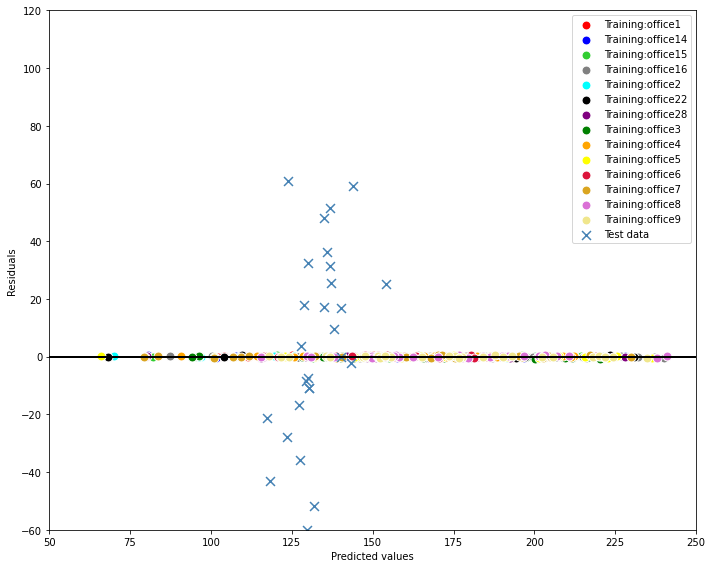

In [61]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = xgb.XGBRegressor(colsample_bytree=study.best_params["colsample_bytree"], 
                              gamma=study.best_params["gamma"],
                              learning_rate=study.best_params["learning_rate"],
                              max_depth=study.best_params["max_depth"], 
                              min_child_weight=study.best_params["min_child_weight"],
                              reg_alpha=study.best_params["reg_alpha"],
                              reg_lambda=study.best_params["reg_lambda"],
                              subsample=study.best_params["subsample"], 
                              n_estimators=1000,
                              booster="gbtree",
                              objective="reg:squarederror",
                              random_state=1,
                              eval_metric=mean_squared_error
                             )


#最適化結果から使ってみたいパラメータを選んでみた
# best_model = SVR(kernel=use_params["kernel"], epsilon=use_params["epsilon"], 
#                  C=use_params["C"], degree=use_params["degree"])

best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")

#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_objective_variable.iloc[train_data_index].index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().reshape(-1), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy().reshape(-1), 
                            office_list=office_list)

## MLP

In [24]:
#GPUの環境変数設定
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(os.environ["CUDA_VISIBLE_DEVICES"])

0


In [25]:
#gpuの確認
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-12-01 05:53:45.803969: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 05:53:47.436481: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2022-12-01 05:53:47.436706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 9410 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:17:00.0, compute capability: 8.6


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9344687171745590145
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9867952128
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12763751048612252149
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:17:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [26]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]

#データをシャッフルする
train_explanatory_variable = train_explanatory_variable.sample(frac=1, random_state=1)
train_objective_variable = train_objective_variable.reindex(index=train_explanatory_variable.index)
test_explanatory_variable = test_explanatory_variable.sample(frac=1, random_state=1)
test_objective_variable = test_objective_variable.reindex(index=test_explanatory_variable.index)
train_explanatory_variable
# train_objective_variable
# test_objective_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office2_360_82_aout,-0.385821,-0.689460,0.228419,-1.347468,0.042324,0.920106,-0.383869,0.316808,1.066746,1.169501,...,2.149953,-1.325558,-0.487173,1.441573,-1.325558,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office5_0_82_aout,-1.384552,-0.689460,0.440009,0.726539,0.042324,-0.707511,0.613681,-0.552901,-1.280259,-1.323330,...,-0.629146,-0.325005,0.546527,-0.361482,-0.325005,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office2_360_82_bout,-0.385821,-0.689460,0.228419,-1.347468,0.042324,0.920106,-0.383869,0.316808,1.066746,1.169501,...,2.149953,-1.325558,-0.487173,1.441573,-1.325558,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office1_0_123_bout,-1.384552,-0.200715,0.734172,-0.525946,1.115353,-0.268377,0.117893,1.186516,-0.923106,0.291383,...,-0.650048,-0.325005,-0.453220,-0.385536,-0.325005,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office16_960_82_bout,1.278731,-0.689460,2.269493,-0.234148,1.115353,2.128733,0.506160,1.186516,1.100760,0.568459,...,-0.378325,-0.325005,0.697432,-0.072839,-0.325005,1.194802,-0.491116,-0.871311,1.147695,-0.398249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office28_960_164_aout,1.278731,0.288031,-1.069509,0.946509,-1.030706,-0.554418,-0.264402,-0.552901,0.808235,0.018570,...,2.292085,1.676099,-0.389085,3.000243,1.676099,1.560022,0.835974,1.147695,-0.871311,-0.398249
office5_360_164_aout,-0.385821,0.288031,0.440009,0.726539,0.042324,-0.707511,0.613681,-0.552901,-1.280259,-1.323330,...,-0.629146,-0.325005,0.546527,-0.361482,-0.325005,-0.996516,0.172429,1.147695,-0.871311,-0.398249
office6_0_164_bout,-1.384552,0.288031,0.720754,-1.755985,1.115353,0.899157,-0.957311,0.316808,1.049058,0.760281,...,0.201908,0.675547,-0.378522,-0.800219,0.675547,-0.996516,0.172429,-0.871311,1.147695,-0.398249
office28_360_164_bout,-0.385821,0.288031,-1.069509,0.946509,-1.030706,-0.554418,-0.264402,-0.552901,0.808235,0.018570,...,2.292085,1.676099,-0.389085,3.000243,1.676099,1.560022,0.835974,-0.871311,1.147695,-0.398249


In [99]:
#base parameter
base_params = {
    "input_dropout" : 0.0,
    "hidden_layers" : 3,
    "hidden_units" : 96,
    "kernel_initializer" : "he_normal",
    "hidden_activation" : "relu",
    "hidden_dropout" : 0.2,
    "batch_norm" : "on",
    "optimizer_type" : "adam", 
    "optimizer_lr" : 0.001,
    "batch_size" : 64,
}

**MLPのハイパーパラメータ一覧**
* 入力層に対するドロップアウト
* 中間層の数
* 中間層のユニット数
* 活性化関数
* 中間層のドロップアウト
* BatchNormalization
* オプティマイザ
* バッチサイズ
* エポック数

In [74]:
#MLPを定義するクラス
class MLP:
    def __init__(self, params):
        self.params = params
        self.model = None
    
    def fit(self, tr_x, tr_y, va_x, va_y, verbose=0, callback_type="early_stopping"):
        
        #パラメータの読み込み
        input_dropout = self.params["input_dropout"]
        hidden_layers = self.params["hidden_layers"]
        hidden_units = self.params["hidden_units"]
        kernel_initializer = self.params["kernel_initializer"]
        hidden_activation = self.params["hidden_activation"]
        hidden_dropout = self.params["hidden_dropout"]
        batch_norm = self.params["batch_norm"]
        optimizer_type = self.params["optimizer_type"]
        optimizer_lr = self.params["optimizer_lr"]
        batch_size = self.params["batch_size"]
        
        #モデルの定義
        self.model = keras.Sequential()
        
        #入力層，kerasはSequentialモデルを作ったとき最初のlayerにinput_shapeまたはinput_dimで入力の形状をtupleで与える必要がある
        self.model.add(Dropout(rate=input_dropout, input_shape=(tr_x.shape[1],)))
        
        #中間層
        for i in range(hidden_layers):
            #全結合層
            self.model.add(Dense(units=hidden_units, kernel_initializer=kernel_initializer))
            #バッチ正規化の有無
            if batch_norm == "on":
                self.model.add(BatchNormalization())
            #活性化関数の選択
            if hidden_activation == "relu":
                self.model.add(ReLU())
            elif hidden_activation == "leaky_relu":
                self.model.add(LeakyReLU(alpha=0.01))
            elif hidden_activation == "prelu":
                self.model.add(PReLU())
            #指定のモノ以外が来たときには埋め込みエラーを吐く
            else:
                raise NotImplementedError
            #ドロップアウト
            self.model.add(Dropout(rate=hidden_dropout))
        
        #出力層
        self.model.add(Dense(1, kernel_initializer=kernel_initializer))
        
        #optimizerの選択
        if optimizer_type == "sgd":
            optimizer = optimizers.SGD(learning_rate=optimizer_lr)
        elif optimizer_type == "adam":
            optimizer = optimizers.Adam(learning_rate=optimizer_lr)
        elif optimizer_type == "rmsprop":
            optimizer = optimizers.RMSprop(learning_rate=optimizer_lr)
        #指定のモノ以外が来たときには埋め込みエラーを吐く
        else:
            raise NotImplementedError
        
        #モデルのcompile
        self.model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])
        
        #学習時の設定
        #エポック
        max_epoch = 400

        #callbackの作成．今のところearlystoppingとtensorboardのみ実装
        #定めたパラメータの最小値更新が行われなければ打ち切り
        patience = 100
        if callback_type == "early_stopping":
            callbacks = [EarlyStopping(monitor="val_mae", patience=patience, verbose=verbose, restore_best_weights=True)]
        elif callback_type == "both":
            #決定したMLPの形状表示
            self.model.summary()
            #tensorboard用のログディレクトリ作成
            control_log = ControlLog()
            log_file_name, log_dir_path = control_log.decide_filename(what_log="TensorBoardLogs")
            tb_log_dir = log_dir_path + log_file_name
            callbacks = [EarlyStopping(monitor="val_mae", patience=patience, verbose=verbose, restore_best_weights=True),
                         TensorBoard(log_dir=tb_log_dir, histogram_freq=1)]
            print("TensorBoardLogs path:", tb_log_dir)

        history = self.model.fit(
            tr_x, tr_y, epochs=max_epoch, batch_size=batch_size, verbose=verbose,
            validation_data=(va_x, va_y), callbacks=callbacks
        )
        
        return history
        
    def predict(self, x):
        #モデルを使用して予測するときにindexを元データと揃えておかないとmean_squared_errorを計算するときにNanとなりerrorが起きる
        y_pred = pd.DataFrame(self.model.predict(x), index=x.index)
        return y_pred

In [101]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        
        #tqdm関連の設定
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの空間設定
        params = {
            "input_dropout" : trial.suggest_float("input_dropout", 0.0, 0.2, step=0.05),
            "hidden_layers" : trial.suggest_int("hidden_layers", 3, 10),
            "hidden_units" : trial.suggest_int("hidden_units", 32, 256, step=32),
            "kernel_initializer" : trial.suggest_categorical("kernel_initializer", ["he_normal", "he_uniform", "random_normal"]),
            "hidden_activation" : trial.suggest_categorical("hidden_activation", ["relu", "leaky_relu", "prelu"]),
            "hidden_dropout" : trial.suggest_float("hidden_dropout", 0.0, 0.3, step=0.05),
            "batch_norm" : trial.suggest_categorical("batch_norm", ["on", "off"]),
            "optimizer_type" : trial.suggest_categorical("optimizer_type", ["adam", "rmsprop"]),
            "optimizer_lr" : trial.suggest_float("optimizer_lr", 1e-4, 1e-2, log=True),
            "batch_size" : trial.suggest_int("batch_size", 32, 128, step=32)
        }
        
        #MLP
        model = MLP(params)
        
        #最適化実行時の評価指標を格納するリスト
        scores = []
        
        #交差検証の分割方法を決定
        #特定のofficeだけ検証用データにする
        validate_office_list = ["office1", "office7", "office16", "office22", "office28"]
        #正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
        office_list = self.X.index.str.extract("(office+[0-9]{1,2})").to_numpy()
        
        for validate_office_name in validate_office_list:
            #リスト内包表記
            validate_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == validate_office_name)]
            #validate_data_index以外をtrain_data_indexとする
            train_data_bool = np.ones(office_list.shape[0], dtype = bool)
            train_data_bool[test_data_index] = False
            train_data_index = np.arange(office_list.shape[0])[train_data_bool]
            
            #トレーニングデータ、検証用データの振り分け
            train_explanatory_variable = self.X.iloc[train_data_index]
            validate_explanatory_variable = self.X.iloc[validate_data_index]
            train_objective_variable = self.y.iloc[train_data_index]
            validate_objective_variable = self.y.iloc[validate_data_index]

            #評価指標の決定，k分割交差検証の実装
            model.fit(tr_x=train_explanatory_variable, tr_y=train_objective_variable, 
                      va_x=validate_explanatory_variable, va_y=validate_objective_variable)
            validate_pred = model.predict(validate_explanatory_variable)
            
            
            #評価関数の計算
            scores.append(mean_squared_error(validate_objective_variable, validate_pred))
            
        self.bar.update(1)
        
        return statistics.mean(scores)

In [ ]:
model_name = "MLP"
#前回の続きから最適化を開始するかのスイッチ．Trueでリスタートする．
restart_switch = False

if restart_switch:
    #前回の続きから最適化を開始してみる(sutdy_nameが残っていないとできない．study_nameが残っていないときはoptunaログから自分で調査して与えればok)
#     study_name = 
    study = optuna.load_study(study_name=model_name+"_"+study_name[0], storage=sqlite_path)
    study.trials_dataframe()
    control_log = ControlLog()
    sqlite_path = control_log.set_log(*study_name)
    
else:
    control_log = ControlLog()
    sqlite_path = control_log.set_log()
    study_name = control_log.decide_filename()


#訓練時のパラメータ設定
n_trials=1000
timeout=None

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
#     study = optuna.create_study(directions=["minimize"], study_name=model_name+"_"+study_name[0],
#                                 sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner(),
#                                 storage=sqlite_path, load_if_exists=True)
    study = optuna.create_study(directions=["minimize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

In [126]:
#探索の結果最も良かったscoreとパラメータの表示
print("探索の結果最良のモデル")
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

探索の結果最良のモデル
best score: 16.963969438912468
best params: {'batch_norm': 'on', 'batch_size': 64, 'hidden_activation': 'relu', 'hidden_dropout': 0.0, 'hidden_layers': 9, 'hidden_units': 224, 'input_dropout': 0.0, 'kernel_initializer': 'he_uniform', 'optimizer_lr': 0.0014261315114980893, 'optimizer_type': 'rmsprop'}


#### 最適化履歴からパラメータを取得

In [30]:
!optuna studies --storage "sqlite:///./OptunaLogs/2022-11-18/optuna.sqlite3"

+---------+---------------+----------+---------------------+
| name    | direction     | n_trials | datetime_start      |
+---------+---------------+----------+---------------------+
| MLP_942 | ('MINIMIZE',) |     1000 | 2022-11-18 09:04:04 |
+---------+---------------+----------+---------------------+


In [31]:
study = optuna.load_study(study_name="MLP_942", storage="sqlite:///./OptunaLogs/2022-11-18/optuna.sqlite3")

In [59]:
#最適化結果の一覧表示
study_value = []
study_params = []
for i in study.trials:
    study_value.append(i.value)
    study_params.append(i.params)
df_study_value = pd.DataFrame(study_value)

#pandasDataFrameのmin等は帰ってくる型がpandasSeries
min_value = df_study_value.min(axis=0)[0]
min_value_index = df_study_value.idxmin(axis=0)[0]#列の最小値のindexを取得
print("最小値", min_value)
print("最小値のindex", min_value_index)

最小値 16.963969438912468
最小値のindex 390


In [60]:
#最適化結果のパラメータを一覧取得
use_params = study_params[min_value_index]
use_params

{'batch_norm': 'on',
 'batch_size': 64,
 'hidden_activation': 'relu',
 'hidden_dropout': 0.0,
 'hidden_layers': 9,
 'hidden_units': 224,
 'input_dropout': 0.0,
 'kernel_initializer': 'he_uniform',
 'optimizer_lr': 0.0014261315114980893,
 'optimizer_type': 'rmsprop'}

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_10 (Dropout)        (None, 22)                0         
                                                                 
 dense_10 (Dense)            (None, 224)               5152      
                                                                 
 batch_normalization_9 (Batc  (None, 224)              896       
 hNormalization)                                                 
                                                                 
 re_lu_9 (ReLU)              (None, 224)               0         
                                                                 
 dropout_11 (Dropout)        (None, 224)               0         
                                                                 
 dense_11 (Dense)            (None, 224)               50400     
                                                      

/mnt/MachineLearning/modules/show_mod.py:86: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


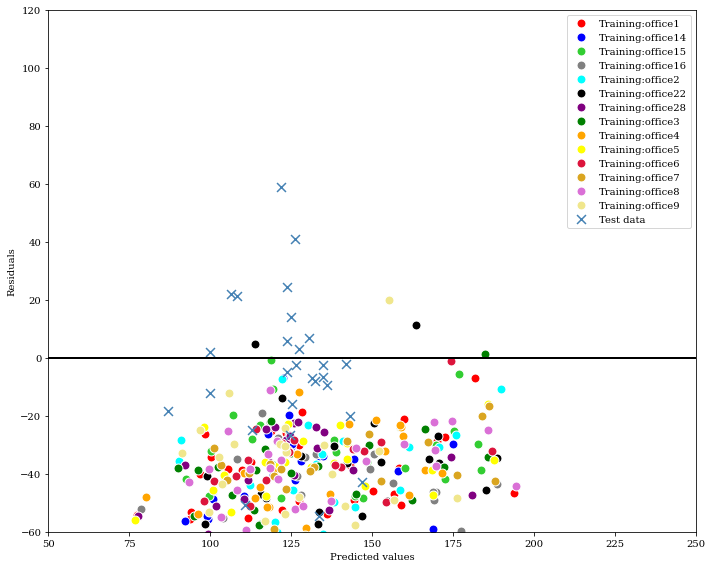

In [72]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価
# best_model = MLP(study.best_params)
#最適化結果から使ってみたいパラメータを選んでみた
best_model = MLP(use_params)

history = best_model.fit(train_explanatory_variable, train_objective_variable, test_explanatory_variable, test_objective_variable, 
                         verbose=1, callback_type="both")
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print("テストデータを用いた結果")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")
print(f"MAE train score:{mean_absolute_error(train_objective_variable, train_pred)}")
print(f"MAE test score:{mean_absolute_error(test_objective_variable, test_pred)}")

#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_objective_variable.iloc[train_data_index].index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred.to_numpy(), train_y=train_pred.to_numpy()-train_objective_variable.to_numpy(), 
                            test_x=test_pred.to_numpy(), test_y=test_pred.to_numpy()-test_objective_variable.to_numpy(), 
                            office_list=office_list)

In [75]:
#TensorBoardの起動
%tensorboard --logdir "./TensorBoardLogs/2022-12-01/73041"

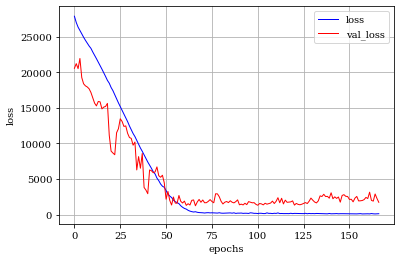

In [69]:
#誤差関数の推移を見てみる
loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig = plt.figure()
plt.rc("font", family="serif")
plt.plot(range(len(loss)), loss, color="blue", linewidth=1, label="loss")
plt.plot(range(len(val_loss)), val_loss, color="red", linewidth=1, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.grid()
plt.show()

# #初めの数エポックの値が大きいのでそこを除いてみる
# trim_position = 30

# #誤差関数
# trim_history = loss[trim_position:]
# trim_val_history = val_loss[trim_position:]

# plt.plot(range(trim_position, len(trim_history) + trim_position), trim_history, "-b", linewidth=1, label="loss")
# plt.plot(range(trim_position, len(trim_val_history) + trim_position), trim_val_history, "-r", linewidth=1, label="val_loss")
# plt.xlabel("Epochs")
# plt.ylabel("Validation LOSS")
# plt.legend(loc="best")
# plt.grid()
# plt.show()

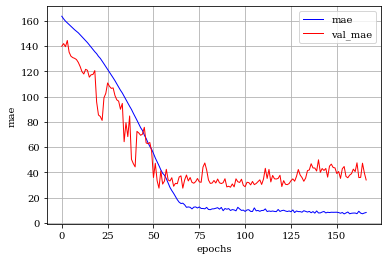

In [70]:
#maeの推移を見てみる
mae = history.history["mae"]
val_mae = history.history["val_mae"]

fig = plt.figure()
plt.rc("font", family="serif")
plt.plot(range(len(mae)), mae, color="blue", linewidth=1, label="mae")
plt.plot(range(len(val_mae)), val_mae, color="red", linewidth=1, label="val_mae")
plt.xlabel("epochs")
plt.ylabel("mae")
plt.legend(loc="best")
plt.grid()
plt.show()

# #初めの数エポックの値が大きいのでそこを除いてみる
# trim_position = 30

# #MAE
# trim_history = mae[trim_position:]
# trim_val_history = val_mae[trim_position:]

# plt.plot(range(trim_position, len(trim_history) + trim_position), trim_history, "-b", linewidth=1, label="loss")
# plt.plot(range(trim_position, len(trim_val_history) + trim_position), trim_val_history, "-r", linewidth=1, label="val_loss")
# plt.xlabel("Epochs")
# plt.ylabel("Validation LOSS")
# plt.legend(loc="best")
# plt.grid()
# plt.show()

### todo
* データ数とバイアス，バリアンスの関係を評価（データ数の問題がわかる可能性あり）
* 座標の対称移動などによるデータ数の増加はやってみる価値あり
* アンサンブル学習（複数のモデルを用いて学習を行い出力値の平均を取る）
* ベイズ推論に触れてみる
* xgboostの結果からも特徴量の重要度を見てみる
* MLPのpredictが何も返してこないことがある